In [ ]:
import pandas as pd
import os
from pyproj import Transformer
import numpy as np
import folium
from folium.plugins import MarkerCluster, HeatMap
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from datetime import datetime
from matplotlib.colors import LogNorm
import requests

# 1. Limpiar datos erróneos en dataset de Autobuses EMT

## Convertir Separador CSV - Autobuses EMT

Este notebook convierte el archivo `stopsemt.csv` de separador coma (`,`) a punto y coma (`;`) para evitar problemas con campos que contienen comas dentro de comillas.

**Input**: `data/AUTOBUSES/stopsemt.csv` (separador: `,`)

**Output**: `data/AUTOBUSES/stopsemt_clean.csv` (separador: `;`)

In [2]:
df = pd.read_csv("data/AUTOBUSES/stopsemt.csv", sep=",", quotechar='"')
df.to_csv("data/AUTOBUSES/stopsemt_clean.csv", sep=";", index=False, quotechar='"')

## Conversión de Coordenadas UTM a Lat/Long
- **Sistema origen**: UTM Zone 30N (EPSG:25830) - coordenadas proyectadas en metros
- **Sistema destino**: WGS84 (EPSG:4326) - coordenadas geográficas en grados decimales
- **Transformación**: Usa `pyproj.Transformer` para conversión precisa
- **Campos afectados**: `posX` (Este → Longitud), `posY` (Norte → Latitud)

In [3]:
autobuses = pd.read_csv('data/AUTOBUSES/stopsemt_clean.csv', sep=';')

transformer = Transformer.from_crs("EPSG:25830", "EPSG:4326", always_xy=True)

lon, lat = transformer.transform(
    autobuses['posX'].values, 
    autobuses['posY'].values
)

autobuses['posX'] = lon
autobuses['posY'] = lat

autobuses.to_csv('data/AUTOBUSES/stopsemt_clean_coordinates_converted.csv', sep=';', index=False)

# 2. Cargar los datos limpios (salida de hop)

In [99]:
df_metro = pd.read_csv('resultados/metro_procesado.csv', sep=';')
df_autobuses = pd.read_csv('resultados/autobuses_procesado.csv', sep=';')
df_bicimad = pd.read_csv('resultados/bicimad_procesado.csv', sep=';')
df_parkings = pd.read_csv('resultados/parkings_procesado.csv', sep=';')
df_viajes = pd.read_csv('data/viajes_madrid.csv', sep=';')

df_all = pd.read_csv('resultados/transporte_madrid_consolidado.csv', sep=';')


In [21]:
df_metro.head()

,stop_id,stop_name,stop_lat,stop_lon,transport_mode
0,par_4_1,PLAZA DE CASTILLA,40.46690,-3.68917,metro
1,acc_4_1_1,Plaza de Castilla,40.46682,-3.68918,metro
2,acc_4_1_1040,Ascensor,40.46555,-3.68877,metro
3,acc_4_1_1043,Intercambiador Superficie,40.46728,-3.68915,metro
4,acc_4_1_1044,Ascensor,40.46702,-3.68918,metro


In [22]:
df_autobuses.head()

,stop_id,stop_name,bus_line,stop_lon,stop_lat,transport_mode
0,4514,Cristo Rey ...,1,-3.716655,40.440258,bus
1,4022,Junta Municipal Moncloa ...,1,-3.717145,40.437624,bus
2,3687,Moncloa ...,1,-3.716809,40.435924,bus
3,737,Altamirano ...,1,-3.716282,40.433990,bus
4,735,Argüelles ...,1,-3.714798,40.431936,bus


In [23]:
df_bicimad.head()

,station_id,station_name,stop_lon,stop_lat,state,capacity,transport_mode
0,2,Metro Callao,-3.705690,40.420400,IN_SERVICE,27,bicimad
1,3,Plaza Conde Suchil,-3.707254,40.430322,IN_SERVICE,19,bicimad
2,4,Malasaña,-3.702500,40.428626,IN_SERVICE,27,bicimad
3,5,Fuencarral,-3.702135,40.428521,IN_SERVICE,27,bicimad
4,6,Colegio de Arquitectos,-3.699023,40.423178,IN_SERVICE,19,bicimad


In [24]:
df_parkings.head()

,parking_id,parking_name,stop_lat,stop_lon,standard_spaces,pmr_spaces,PMR_ratio,transport_mode
0,2,Colón,40.424709,-3.689939,1047,21,0.020057,parking
1,3,Corazón de María II,40.438525,-3.645525,327,0,0.000000,parking
2,4,Encuentro,40.405465,-3.651354,104,0,0.000000,parking
3,5,Nuestra Señora del Recuerdo,40.472181,-3.679160,902,12,0.013304,parking
4,6,Corona Boreal,40.456800,-3.783200,120,0,0.000000,parking


In [3]:
df_viajes.head()

,Codigo,Provincia,distrito,name,poblacion,fecha,edad,sexo,numero_viajes,personas
0,28,Madrid,2807901,Centro,140644,202401,0-25,hombre,0,90541.756
1,28,Madrid,2807901,Centro,140644,202401,0-25,hombre,1,18809.207
2,28,Madrid,2807901,Centro,140644,202401,0-25,hombre,2,73248.991
3,28,Madrid,2807901,Centro,140644,202401,0-25,hombre,2+,187551.534
4,28,Madrid,2807901,Centro,140644,202401,0-25,mujer,0,75357.987


In [25]:
df_all.head()

,stop_name,stop_lat,stop_lon,transport_mode,stop_id
0,PLAZA DE CASTILLA ...,40.46690,-3.68917,metro ...,par_4_1 ...
1,Plaza de Castilla ...,40.46682,-3.68918,metro ...,acc_4_1_1 ...
2,Ascensor ...,40.46555,-3.68877,metro ...,acc_4_1_1040 ...
3,Intercambiador Superficie ...,40.46728,-3.68915,metro ...,acc_4_1_1043 ...
4,Ascensor ...,40.46702,-3.68918,metro ...,acc_4_1_1044 ...


In [10]:
print(f"Metro: {len(df_metro)} paradas")
print(f"Autobuses: {len(df_autobuses)} paradas")
print(f"BiciMAD: {len(df_bicimad)} estaciones")
print(f"Parkings: {len(df_parkings)} parkings")

Metro: 128 paradas
Autobuses: 18 paradas
BiciMAD: 6 estaciones
Parkings: 7 parkings


# 3. Análisis de datos

### Mapa de cobertura

In [ ]:
OUTPUT_MAP = 'resultados/mapa_cobertura.html'

def calcular_densidad(metro, bus, bici, parkings):
    print("\nCalculando densidad de estaciones...")
    STEP = 0.0045
    
    bici_aux = bici.rename(columns={'station_name': 'stop_name'})
    
    df_all = pd.concat([
        metro[['stop_lat', 'stop_lon']],
        bus[['stop_lat', 'stop_lon']],
        bici_aux[['stop_lat', 'stop_lon']],
        parkings[['stop_lat', 'stop_lon']]
    ])
    
    df_all['lat_bin'] = (df_all['stop_lat'] / STEP).round().astype(int)
    df_all['lon_bin'] = (df_all['stop_lon'] / STEP).round().astype(int)
    
    density = df_all.groupby(['lat_bin', 'lon_bin']).size().reset_index(name='count')
    density['lat_center'] = density['lat_bin'] * STEP
    density['lon_center'] = density['lon_bin'] * STEP
    
    return density

def crear_mapa(metro, bus, bici, parkings):
    print("\nGenerando mapa...")
    m = folium.Map(location=[40.416775, -3.703790], zoom_start=12, tiles='CartoDB positron')
    
    # Capas
    layer_metro = folium.FeatureGroup(name='Metro (Azul)')
    layer_bus = folium.FeatureGroup(name='Autobús (Verde)')
    layer_bici = folium.FeatureGroup(name='BiciMAD (Rojo)')
    layer_parkings = folium.FeatureGroup(name='Parkings (Naranja)')
    
    # Añadir puntos Metro
    for idx, row in metro.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=4,
            color='blue',
            fill=True,
            fill_opacity=0.7,
            popup=f"Metro: {row['stop_name']}"
        ).add_to(layer_metro)
        
    # Añadir puntos Bus
    for idx, row in bus.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=2,
            color='green',
            fill=True,
            fill_opacity=0.5,
            popup=f"Bus: {row['stop_name']}"
        ).add_to(layer_bus)
        
    # Añadir puntos Bici
    for idx, row in bici.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=3,
            color='red',
            fill=True,
            fill_opacity=0.6,
            popup=f"Bici: {row['station_name']}"
        ).add_to(layer_bici)
    
    # Añadir puntos Parkings
    for idx, row in parkings.iterrows():
        folium.CircleMarker(
            location=[row['stop_lat'], row['stop_lon']],
            radius=5,
            color='orange',
            fill=True,
            fill_opacity=0.8,
            popup=f"Parking: {row['parking_name']}"
        ).add_to(layer_parkings)

    layer_metro.add_to(m)
    layer_bus.add_to(m)
    layer_bici.add_to(m)
    layer_parkings.add_to(m)
    
    folium.LayerControl().add_to(m)
    
    m.save(OUTPUT_MAP)
    print(f"Mapa guardado en: {OUTPUT_MAP}")


Calculando densidad de estaciones...
Top 10 zonas con mayor densidad de transporte:
     lat_bin  lon_bin  count  lat_center  lon_center
357     8980     -820     55     40.4100     -3.6900
634     8991     -817     52     40.4595     -3.6765
422     8983     -820     42     40.4235     -3.6900
317     8979     -825     38     40.4055     -3.7125
402     8982     -821     36     40.4190     -3.6945
512     8986     -820     36     40.4370     -3.6900
513     8986     -819     36     40.4370     -3.6855
425     8983     -817     34     40.4235     -3.6765
418     8983     -824     34     40.4235     -3.7080
417     8983     -825     32     40.4235     -3.7125

Generando mapa...
Mapa guardado en: resultados/mapa_cobertura.html
Análisis completado.


### Análisis multimodal

In [52]:
# Configuración de estilo
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (20, 24) # Hacemos el lienzo grande para que quepan todas
plt.rcParams['font.size'] = 11

# Factor de conversión aproximado para Madrid (grados a metros)
FACTOR_LAT = 111000
FACTOR_LON = 111000 * np.cos(np.radians(40.4))

def get_coords_meters(df):
    coords = df[['stop_lat', 'stop_lon']].values.copy()
    coords[:, 0] *= FACTOR_LAT
    coords[:, 1] *= FACTOR_LON
    return coords

# Coordenadas en metros
coords_bicimad = get_coords_meters(df_bicimad)
coords_metro = get_coords_meters(df_metro)
coords_bus = get_coords_meters(df_autobuses)
coords_parking = get_coords_meters(df_parkings)

## Cálculos para BiciMAD
# Distancia al Metro más cercano
dists_bici_metro = cdist(coords_bicimad, coords_metro).min(axis=1)
# Distancia al Bus más cercano
dists_bici_bus = cdist(coords_bicimad, coords_bus).min(axis=1)

df_bicimad_plot = df_bicimad.copy()
df_bicimad_plot['dist_metro'] = dists_bici_metro
df_bicimad_plot['dist_bus'] = dists_bici_bus
# Categoría de integración
df_bicimad_plot['integracion'] = np.where(df_bicimad_plot['dist_metro'] < 350, 'Alta (<350m)', 
                                 np.where(df_bicimad_plot['dist_metro'] < 600, 'Media (350-600m)', 'Baja (>600m)'))

## Cálculos para metro
# Contar cuántos buses y bicis hay cerca de cada metro (en un radio de 350m)
matrix_metro_bus = cdist(coords_metro, coords_bus)
matrix_metro_bici = cdist(coords_metro, coords_bicimad)

df_metro_plot = df_metro.copy()
df_metro_plot['buses_cercanos'] = (matrix_metro_bus < 350).sum(axis=1)
df_metro_plot['bicis_cercanas'] = (matrix_metro_bici < 350).sum(axis=1)

# Determinar línea
if 'Line' not in df_metro_plot.columns:
    df_metro_plot['Line'] = 'L' + df_metro_plot.index.astype(str).str[-1] 

# Clasificación de multimodalidad
def nivel_multimodal(row):
    modos = 1
    if row['buses_cercanos'] > 0: modos += 1
    if row['bicis_cercanas'] > 0: modos += 1
    return f"{modos} Modos"

df_metro_plot['nivel_multimodal'] = df_metro_plot.apply(nivel_multimodal, axis=1)

# Cálculos para parkings
dists_park_metro = cdist(coords_parking, coords_metro).min(axis=1)
df_parking_plot = df_parkings.copy()
df_parking_plot['dist_metro'] = dists_park_metro
df_parking_plot['capacity'] = df_parking_plot['pmr_spaces'] + df_parking_plot['standard_spaces']

- Histograma con la frecuencia de estaciones BiciMAD según distancia al metro + histograma con la misma frecuencia para los buses, con opacidad baja para que se puedan ver las superposiciones, si hay

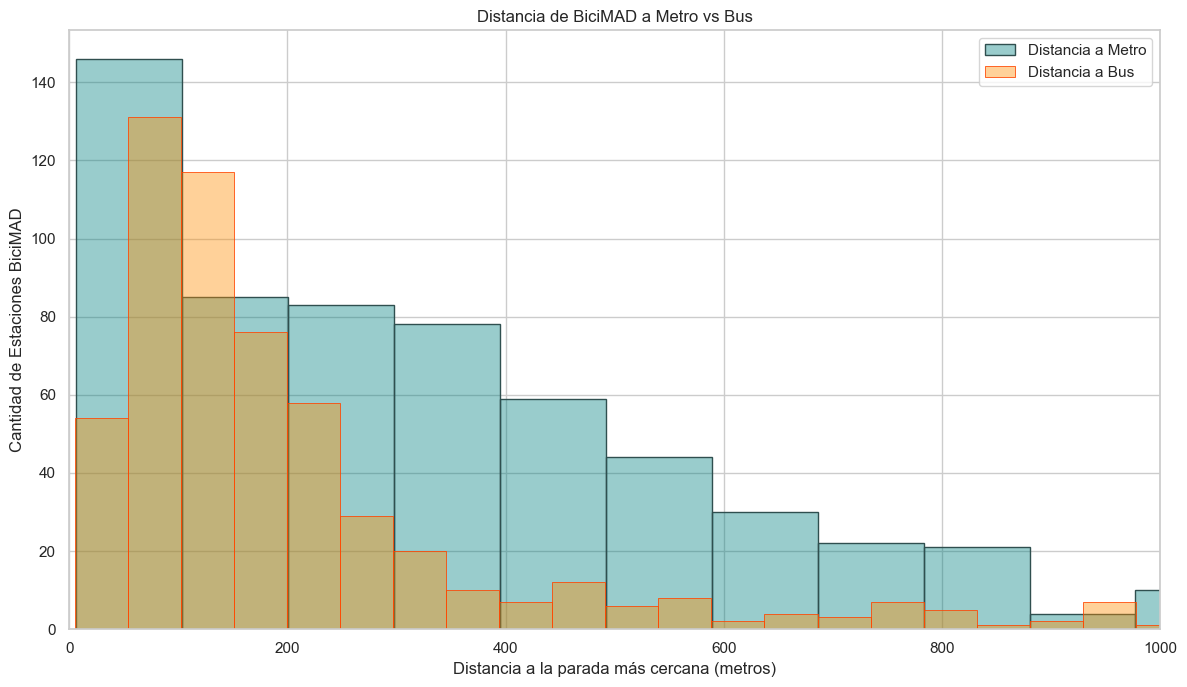

In [53]:
plt.figure(figsize=(12, 7))

# Histograma 1: Distancia a metro
sns.histplot(
    data=df_bicimad_plot, 
    x='dist_metro', 
    color='teal', 
    label='Distancia a Metro', 
    kde=False, 
    alpha=0.4,
    edgecolor='darkslategray'
)

# Histograma 2: Distancia a bus
sns.histplot(
    data=df_bicimad_plot, 
    x='dist_bus', 
    color='darkorange', 
    label='Distancia a Bus', 
    kde=False, 
    alpha=0.4,
    edgecolor='orangered'
)

plt.title('Distancia de BiciMAD a Metro vs Bus')
plt.xlabel('Distancia a la parada más cercana (metros)')
plt.ylabel('Cantidad de Estaciones BiciMAD')
plt.legend()

plt.xlim(0, 1000)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_multimodal/1_histograma_comparativo_metro_bus.png', dpi=300)
plt.show()

- Scatter plot. Cada punto es una estación de Metro. Eje X = Nº de paradas de Bus cercanas; Eje Y = Nº de bases BiciMAD cercanas.

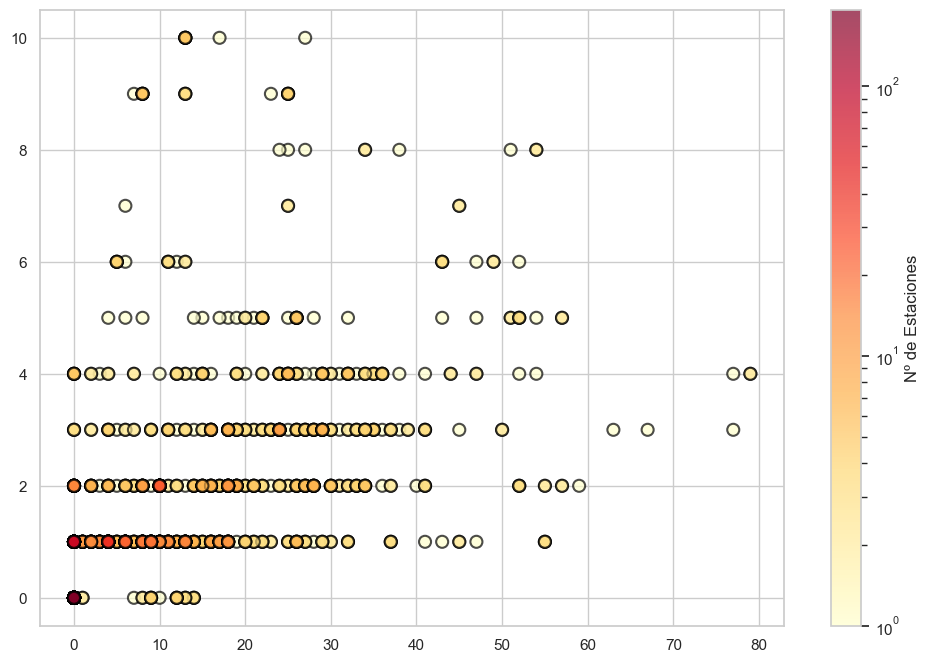

In [63]:
plt.figure(figsize=(12, 8))

df_metro_plot['densidad_punto'] = df_metro_plot.groupby(['buses_cercanos', 'bicis_cercanas'])['stop_name'].transform('count')
df_metro_plot = df_metro_plot.sort_values('densidad_punto')

valores_unicos = sorted(df_metro_plot['densidad_punto'].unique())

# Usar normalización logarítmica para mejor distribución de colores
norm = LogNorm(vmin=df_metro_plot['densidad_punto'].min(), 
               vmax=df_metro_plot['densidad_punto'].max())

scatter = plt.scatter(
    df_metro_plot['buses_cercanos'], 
    df_metro_plot['bicis_cercanas'],
    s=75,
    c=df_metro_plot['densidad_punto'],
    cmap='YlOrRd', 
    alpha=0.7,
    edgecolor='black',
    linewidth=1.5,
    norm=norm
)

plt.colorbar(scatter, label='Nº de Estaciones')

- Scatter Plot de Eficiencia Park & Ride (Distancia vs. Capacidad). Cada punto es un Parking. Eje X = Distancia a la estación de transporte público; Eje Y = Capacidad del parking.

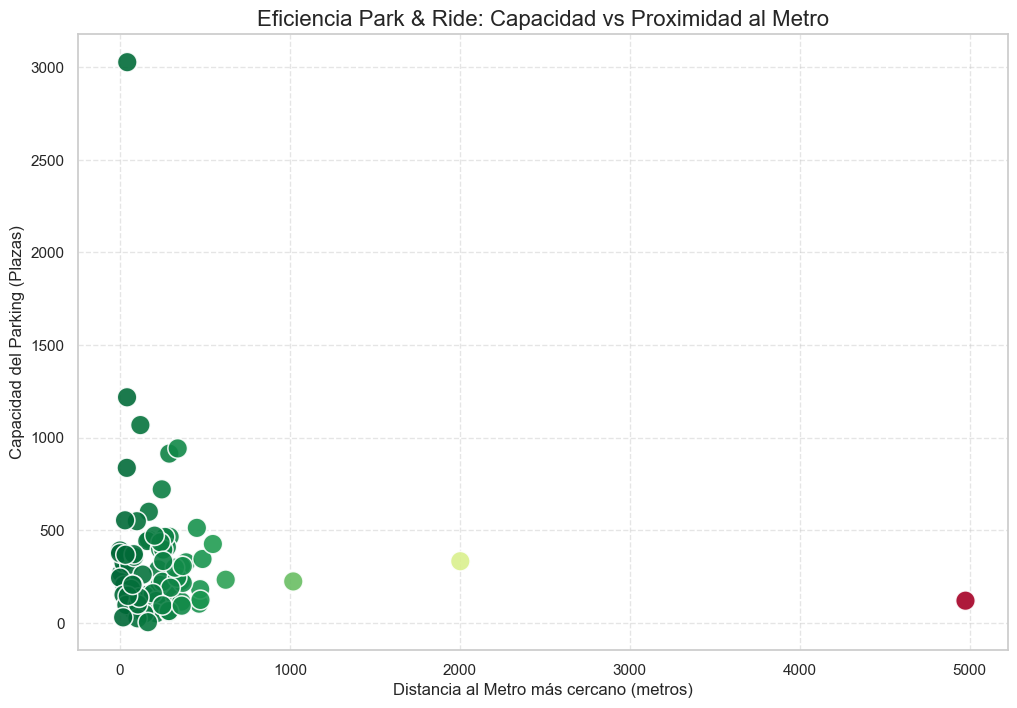

In [64]:
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=df_parking_plot, 
    x='dist_metro', 
    y='capacity', 
    hue='dist_metro',       # El color indica la distancia (Verde=Cerca, Rojo=Lejos)
    palette='RdYlGn_r',
    s=200,
    alpha=0.9
)

plt.title('Eficiencia Park & Ride: Capacidad vs Proximidad al Metro', fontsize=16)
plt.xlabel('Distancia al Metro más cercano (metros)', fontsize=12)
plt.ylabel('Capacidad del Parking (Plazas)', fontsize=12)

plt.grid(True, linestyle='--', alpha=0.5)

plt.legend([], [], frameon=False)

plt.savefig('resultados/plots/analisis_multimodal/3_scatter_efficiency_parkings.png', dpi=300, bbox_inches='tight')
plt.show()

- Boxplot de Comparativa de Modos. Dos cajas una al lado de la otra. Una muestra la distribución de distancias Bici -> Metro y la otra Bici -> Bus.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/229876118.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


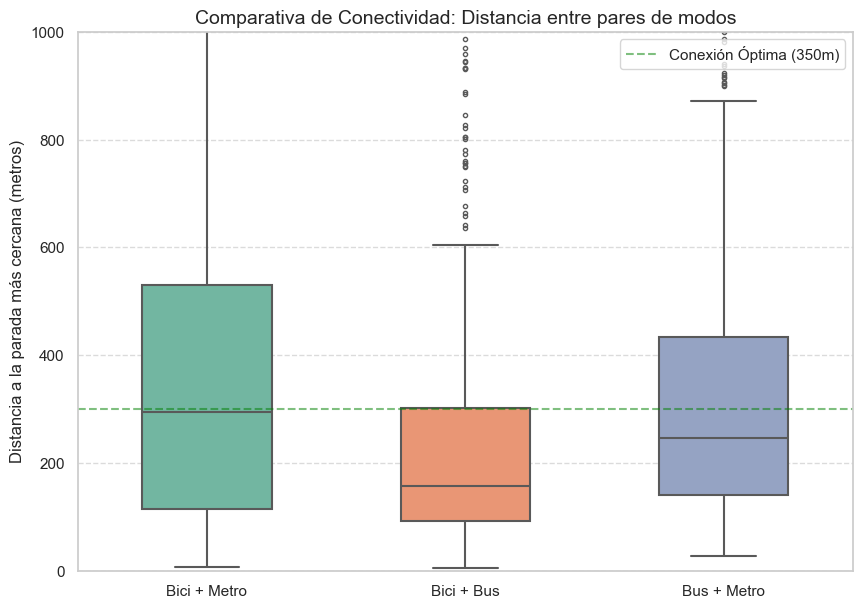

In [65]:
plt.figure(figsize=(10, 7))

df_comparativa = df_bicimad_plot[['dist_metro', 'dist_bus']].copy()

df_comparativa['dist_bus_metro'] = (df_comparativa['dist_metro'] + df_comparativa['dist_bus']) / 2

df_melt = df_comparativa.melt(
    var_name='Modo_Transporte', 
    value_name='Distancia'
)

df_melt['Modo_Transporte'] = df_melt['Modo_Transporte'].replace({
    'dist_metro': 'Bici + Metro', 
    'dist_bus': 'Bici + Bus',
    'dist_bus_metro': 'Bus + Metro'
})

sns.boxplot(
    data=df_melt,
    x='Modo_Transporte',
    y='Distancia',
    palette="Set2",
    width=0.5,
    fliersize=3,
    linewidth=1.5
)

plt.title('Comparativa de Conectividad: Distancia entre pares de modos', fontsize=14)
plt.ylabel('Distancia a la parada más cercana (metros)', fontsize=12)
plt.xlabel('') 

plt.ylim(0, 1000)

plt.axhline(300, color='green', linestyle='--', alpha=0.5, label='Conexión Óptima (350m)')
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('resultados/plots/analisis_multimodal/4_boxplot_comparativa_modos.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

- Gráfico de Barras por Línea de Metro (Ranking de Conectividad). Qué muestra: Eje X = Líneas de Metro (L1, L2...); Eje Y = Promedio de bases de bici o paradas de bus por estación de esa línea.

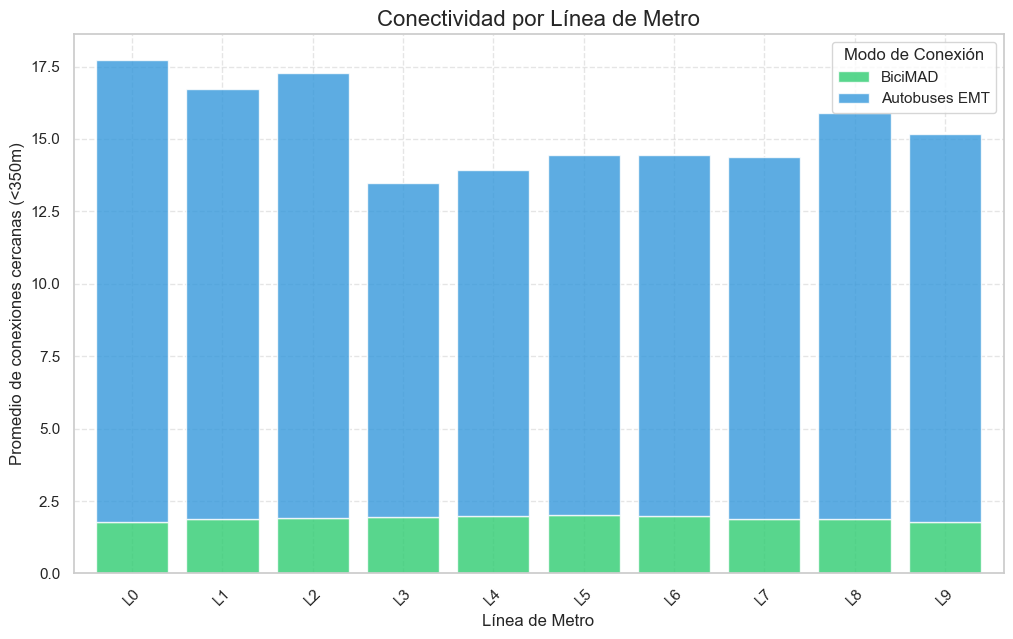

In [66]:
plt.figure(figsize=(12, 7))

line_stats = df_metro_plot.groupby('Line')[['bicis_cercanas', 'buses_cercanos']].mean()

line_stats_sorted = line_stats.sort_index()

line_stats_sorted.plot(
    kind='bar',
    stacked=True,
    color=['#2ecc71', '#3498db'],  # Verde para bicis, Azul para buses
    alpha=0.8,
    width=0.8,
    ax=plt.gca()
)

plt.title('Conectividad por Línea de Metro', fontsize=16)
plt.xlabel('Línea de Metro', fontsize=12)
plt.ylabel('Promedio de conexiones cercanas (<350m)', fontsize=12)
plt.xticks(rotation=45)

plt.legend(['BiciMAD', 'Autobuses EMT'], title='Modo de Conexión', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.5)

plt.savefig('resultados/plots/analisis_multimodal/5_ranking_lineas_metro.png', format='png', dpi=300, bbox_inches='tight')
plt.show()


- Gráfico de Violín de Capacidad vs. Conexión. Eje X = ¿Es nodo intermodal? (Sí/No); Eje Y = Capacidad de la estación de BiciMAD.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/1353256977.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/1353256977.py:23: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(range(len(means)), means.values, 'ro', label='Media',markersize=8, color='crimson')
/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/1353256977.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/1353256977.py:42: UserWarning: co

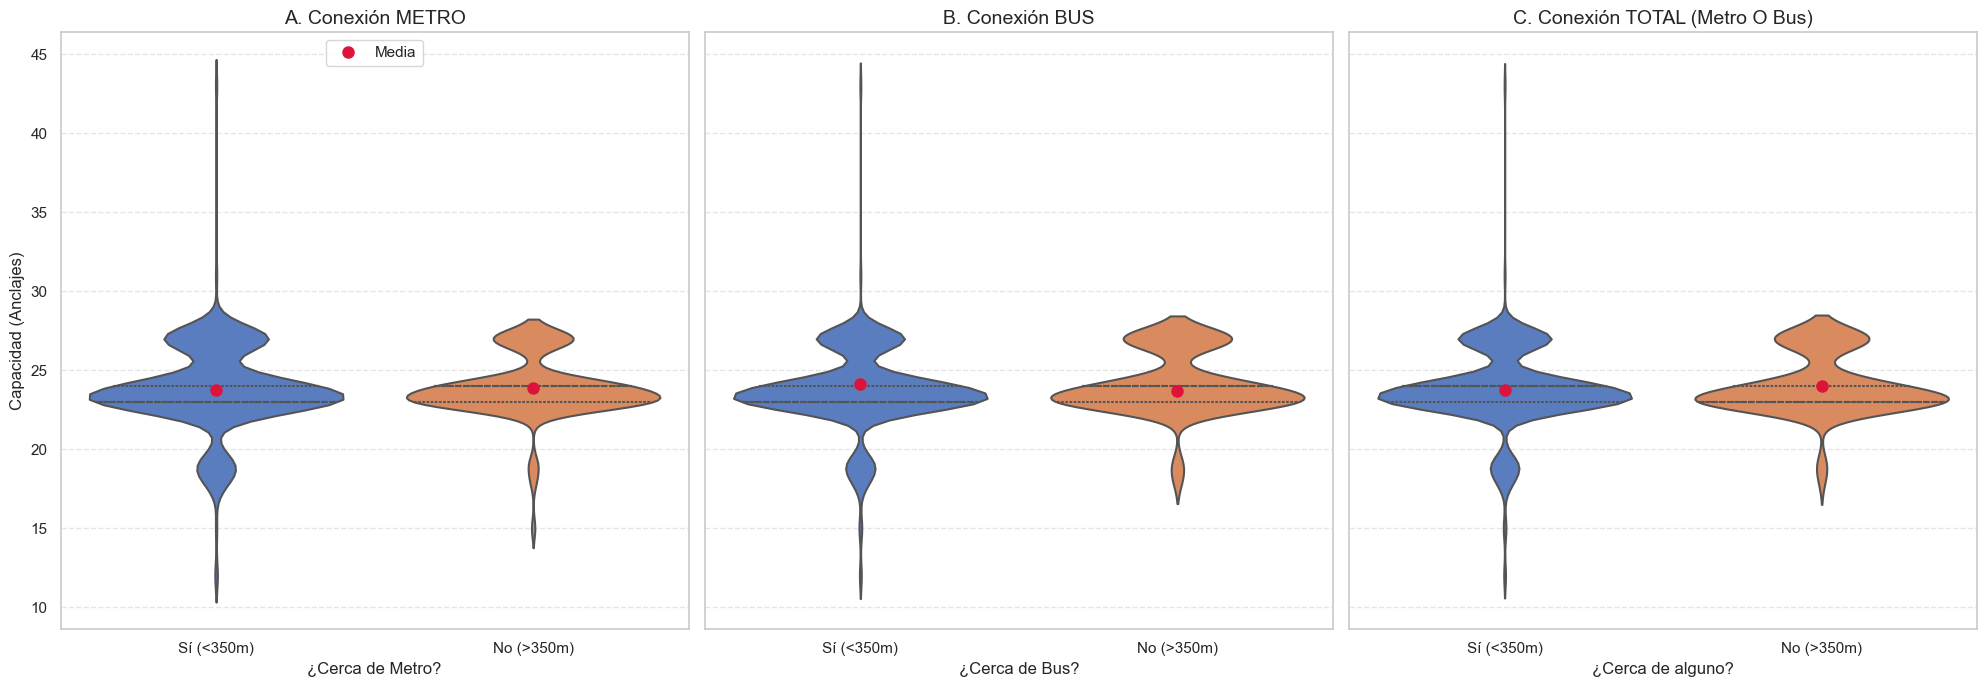

In [67]:
fig, axes = plt.subplots(1, 3, figsize=(20, 7), sharey=True)

# Para evitar errores, hacemos una copia segura
df_violin = df_bicimad_plot.copy()

# PLOT 1: METRO
ax = axes[0]
df_violin['condicion'] = np.where(df_violin['dist_metro'] < 350, 'Sí (<350m)', 'No (>350m)')

categorias_validas = df_violin['condicion'].value_counts()
categorias_validas = categorias_validas[categorias_validas > 0].index.tolist()

sns.violinplot(
    data=df_violin, x='condicion', y='capacity',
    palette="muted", inner="quartile", linewidth=1.5, ax=ax
)
ax.set_title('A. Conexión METRO', fontsize=14)
ax.set_xlabel('¿Cerca de Metro?')
ax.set_ylabel('Capacidad (Anclajes)')

# Medias
means = df_violin.groupby('condicion')['capacity'].mean().reindex(categorias_validas)
ax.plot(range(len(means)), means.values, 'ro', label='Media',markersize=8, color='crimson')
ax.legend(loc='upper center')
ax.grid(axis='y', linestyle='--', alpha=0.5)


# PLOT 2: BUS
ax = axes[1]
df_violin['condicion'] = np.where(df_violin['dist_bus'] < 350, 'Sí (<350m)', 'No (>350m)')

sns.violinplot(
    data=df_violin, x='condicion', y='capacity',
    palette="muted", inner="quartile", linewidth=1.5, ax=ax
)
ax.set_title('B. Conexión BUS', fontsize=14)
ax.set_xlabel('¿Cerca de Bus?')
ax.set_ylabel('')

# Medias
means = df_violin.groupby('condicion')['capacity'].mean()
ax.plot(range(len(means)), means.values, 'ro', markersize=8, color='crimson')
ax.grid(axis='y', linestyle='--', alpha=0.5)


# PLOT 3: AMBOS (Intermodalidad Total)
ax = axes[2]
df_violin['condicion'] = np.where(
    (df_violin['dist_metro'] < 350) | (df_violin['dist_bus'] < 350),
    'Sí (<350m)',
    'No (>350m)'
)

categorias_validas = df_violin['condicion'].value_counts()
categorias_validas = categorias_validas[categorias_validas > 0].index.tolist()

sns.violinplot(
    data=df_violin[df_violin['condicion'].isin(categorias_validas)],
    x='condicion',
    y='capacity',
    palette="muted", 
    inner="quartile", 
    linewidth=1.5, 
    ax=ax,
    order=categorias_validas
)

ax.set_title('C. Conexión TOTAL (Metro O Bus)', fontsize=14)
ax.set_xlabel('¿Cerca de alguno?')
ax.set_ylabel('')

# Medias
means = df_violin.groupby('condicion')['capacity'].mean().reindex(categorias_validas)
ax.plot(range(len(means)), means.values, 'ro', markersize=8, color='crimson')
ax.grid(axis='y', linestyle='--', alpha=0.5)


plt.tight_layout()
plt.savefig('resultados/plots/analisis_multimodal/6_violin_capacidad_conexion.png', dpi=300, bbox_inches='tight')
plt.show()

- Gráfico de Barras Apiladas (Stacked Bar) de Disponibilidad. Una barra única o por distritos, dividida en colores: "% Estaciones con 3 modos", "% con 2 modos", "% Aisladas".

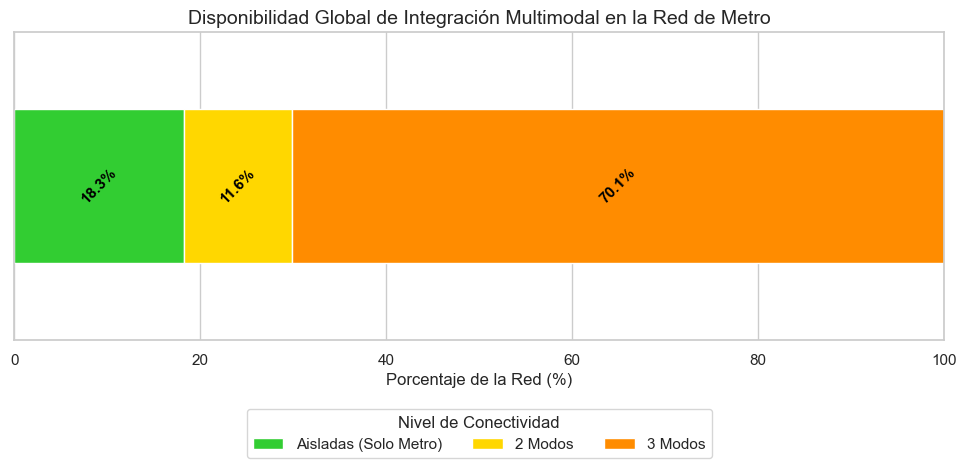

In [68]:
plt.figure(figsize=(12, 5))

conteo = df_metro_plot['nivel_multimodal'].value_counts(normalize=True) * 100

categorias_posibles = ['1 Modos', '2 Modos', '3 Modos']
conteo = conteo.reindex(categorias_posibles, fill_value=0)

df_stack = pd.DataFrame(conteo).T

df_stack = df_stack.rename(columns={
    '1 Modos': 'Aisladas (Solo Metro)',
    '2 Modos (Metro + Bus/Bici)': '2 Modos (Metro + Bus/Bici)',
    '3 Modos (Metro + Bus + Bici)': '3 Modos (Metro + Bus + Bici)'
})

ax = df_stack.plot(
    kind='barh', 
    stacked=True, 
    color=['limegreen', 'gold', 'darkorange'],
    width=0.5,
    figsize=(12, 4),
    ax=plt.gca()
)

plt.title('Disponibilidad Global de Integración Multimodal en la Red de Metro', fontsize=14)
plt.xlabel('Porcentaje de la Red (%)', fontsize=12)
plt.yticks([]) 
plt.xlim(0, 100)

for c in ax.containers:
    labels = [f'{v.get_width():.1f}%' if v.get_width() > 0 else '' for v in c]
    ax.bar_label(c, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='black', rotation=45)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, title='Nivel de Conectividad')

plt.savefig('resultados/plots/analisis_multimodal/7_stacked_bar_disponibilidad.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Análisis de Accesibilidad (PMR - Personas con Movilidad Reducida)

In [70]:
df_accesibilidad = df_parkings.copy()

df_accesibilidad['total_plazas'] = df_accesibilidad['standard_spaces'] + df_accesibilidad['pmr_spaces']

df_accesibilidad['pmr_ratio'] = df_accesibilidad.apply(
    lambda row: (row['pmr_spaces'] / row['total_plazas'] * 100) if row['total_plazas'] > 0 else 0, 
    axis=1
)

df_accesibilidad['tiene_pmr'] = np.where(df_accesibilidad['pmr_spaces'] > 0, 'Con PMR', 'Sin PMR')

df_con_pmr = df_accesibilidad[df_accesibilidad['pmr_spaces'] > 0].copy()

conteo_accesibilidad = df_accesibilidad['tiene_pmr'].value_counts()

- Gráfico de Pastel: Porcentaje de Parkings Adaptados. Un gráfico circular hueco. Una sección muestra el % de parkings con al menos 1 plaza PMR y la otra los que tienen 0 plazas.

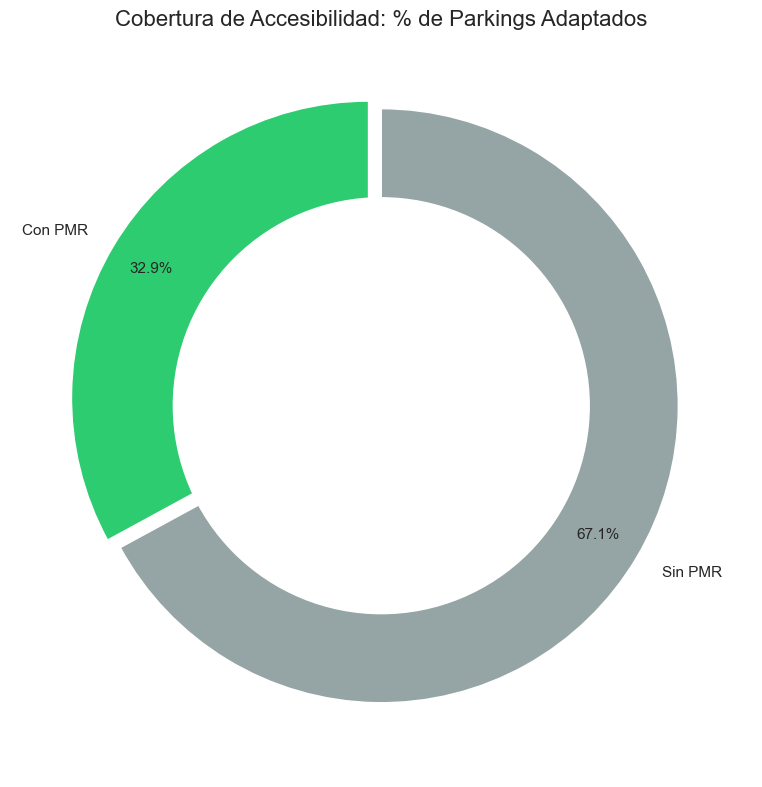

In [71]:
plt.figure(figsize=(8, 8))

datos_plot = conteo_accesibilidad.reindex(['Con PMR', 'Sin PMR'])

colores = ['#2ecc71', '#95a5a6'] 
explode = (0.05, 0)

plt.pie(
    datos_plot, 
    labels=datos_plot.index, 
    colors=colores,
    autopct='%1.1f%%',       
    startangle=90,           
    pctdistance=0.85,        
    explode=explode,
    wedgeprops=dict(width=0.4, edgecolor='w') # Ancho del donut
)

centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Cobertura de Accesibilidad: % de Parkings Adaptados', fontsize=16)
plt.tight_layout()

plt.savefig('resultados/plots/analisis_accesibilidad/1_donut_cobertura_pmr.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

- Ranking de de Accesibilidad (Bar Plot Horizontal). Qué muestra: Los 3 parkings con mejor Ratio PMR (no números absolutos, sino %).

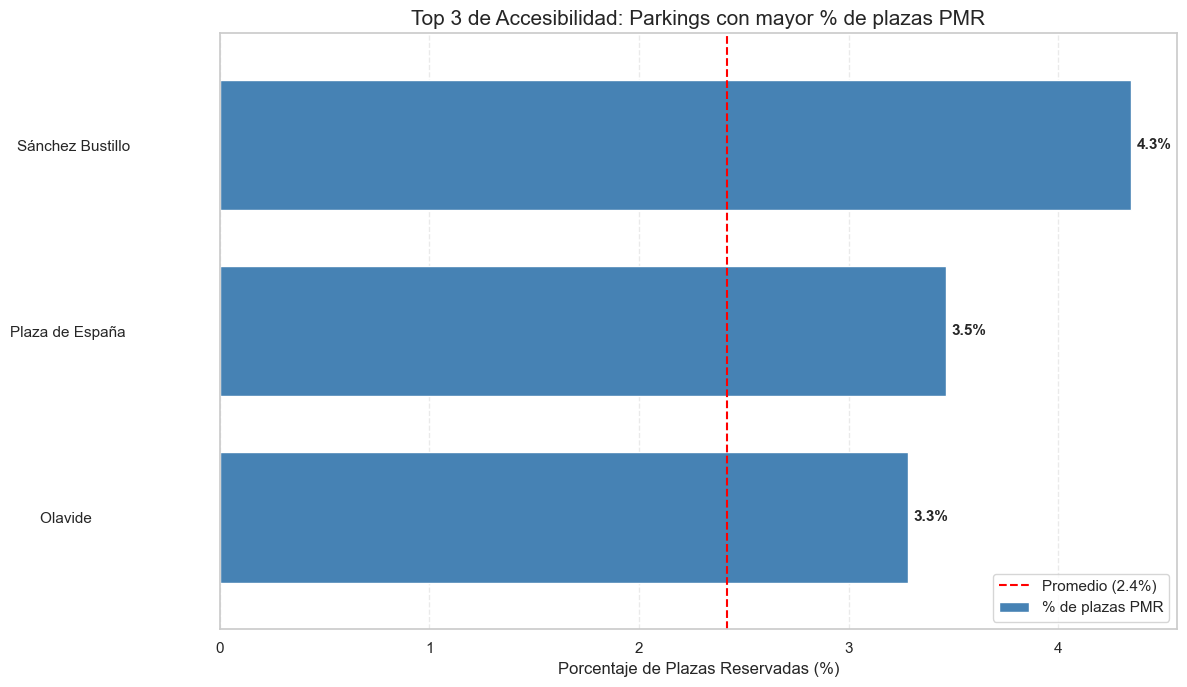

In [72]:
plt.figure(figsize=(12, 7))

top_3_pmr = df_con_pmr.nlargest(3, 'pmr_ratio').sort_values('pmr_ratio', ascending=True)

ax = top_3_pmr.plot(
    kind='barh',
    x='parking_name',
    y='pmr_ratio',
    color='steelblue',
    width=0.7,
    figsize=(12, 7),
    label='% de plazas PMR',
    legend=False,
    ax=plt.gca()
)

plt.title('Top 3 de Accesibilidad: Parkings con mayor % de plazas PMR', fontsize=15)
plt.xlabel('Porcentaje de Plazas Reservadas (%)', fontsize=12)
plt.ylabel('')

for c in ax.containers:
    ax.bar_label(c, fmt='%.1f%%', padding=4, fontsize=11, fontweight='bold')

media_ratio = df_con_pmr['pmr_ratio'].mean()
plt.axvline(media_ratio, color='red', linestyle='--', label=f'Promedio ({media_ratio:.1f}%)')
plt.legend()

plt.grid(axis='x', linestyle='--', alpha=0.4)
plt.grid(axis='y', alpha=0)

plt.tight_layout()

plt.savefig('resultados/plots/analisis_accesibilidad/2_ranking_pmr.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

- Boxplot: Tamaño de Infraestructura (Con PMR vs Sin PMR). sDos cajas. Una para los parkings que Tienen PMR y otra para los que No. Eje Y = Capacidad Total.

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/2371126607.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/2371126607.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(range(len(orden_eje)), [medias[cat] for cat in orden_eje], 'ro', label='Media', markersize=8, color='crimson')


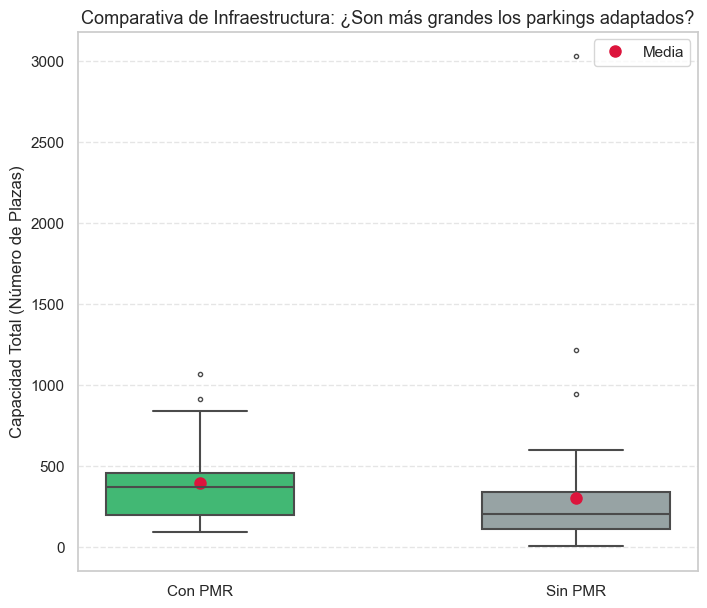

In [73]:
plt.figure(figsize=(8, 7))

sns.boxplot(
    data=df_accesibilidad,
    x='tiene_pmr',
    y='total_plazas',
    palette={'Con PMR': '#2ecc71', 'Sin PMR': '#95a5a6'},
    width=0.5,
    linewidth=1.5,
    fliersize=3 
)

plt.title('Comparativa de Infraestructura: ¿Son más grandes los parkings adaptados?', fontsize=13)
plt.xlabel('')
plt.ylabel('Capacidad Total (Número de Plazas)', fontsize=12)

medias = df_accesibilidad.groupby('tiene_pmr')['total_plazas'].mean()
orden_eje = ['Con PMR', 'Sin PMR'] 
plt.plot(range(len(orden_eje)), [medias[cat] for cat in orden_eje], 'ro', label='Media', markersize=8, color='crimson')

plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.savefig('resultados/plots/analisis_accesibilidad/4_boxplot_tamano_infraestructura.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

### Análisis Temporal de Líneas de Autobús EMT

In [82]:
df_lines = pd.read_csv('data/AUTOBUSES/linesemt.csv', sep=',')

df_lines['dateIni'] = pd.to_datetime(df_lines['dateIni'], errors='coerce')
df_lines['dateEnd'] = pd.to_datetime(df_lines['dateEnd'], errors='coerce')

df_lines = df_lines[df_lines['dateIni'] < '2026-01-01'] 
df_lines = df_lines[df_lines['dateEnd'] < '2026-01-01']

if 'nameTo' in df_lines.columns:
    df_lines = df_lines[~df_lines['nameTo'].str.contains('PRUEBAS', na=False, case=False)]

df_lines['duracion_dias'] = (df_lines['dateEnd'] - df_lines['dateIni']).dt.days
df_lines['año_inicio'] = df_lines['dateIni'].dt.year
df_lines['es_especial'] = df_lines['label'].str.startswith('SE', na=False)

conteo_anual = df_lines.groupby('año_inicio')['line'].nunique().dropna().sort_index()

df_vida_lineas = df_lines.groupby('line').agg({
    'dateIni': 'min',
    'dateEnd': 'max'
}).reset_index()

df_vida_lineas['duracion_dias'] = (df_vida_lineas['dateEnd'] - df_vida_lineas['dateIni']).dt.days
df_duracion_valid = df_vida_lineas.dropna(subset=['duracion_dias'])
df_duracion_valid = df_duracion_valid[df_duracion_valid['duracion_dias'] > 0]

conteo_tipos = df_lines['es_especial'].value_counts().rename({False: 'Regulares', True: 'Especiales'})

top_depositos = df_lines['depo'].value_counts().head(10)

top_longevas = df_lines.nlargest(10, 'duracion_dias').copy()
top_longevas['label_full'] = top_longevas['label'] + ' (' + top_longevas['nameFrom'] + ' - ' + top_longevas['nameTo'] + ')'
top_longevas = top_longevas.sort_values('duracion_dias', ascending=True)

top_longevas['duracion_anos'] = top_longevas['duracion_dias'] / 365

- Gráfico de Barras Verticales (Temporal): Para visualizar la "Evolución de nuevas líneas por año". Nos dirá cuándo hubo "booms" de creación de líneas.

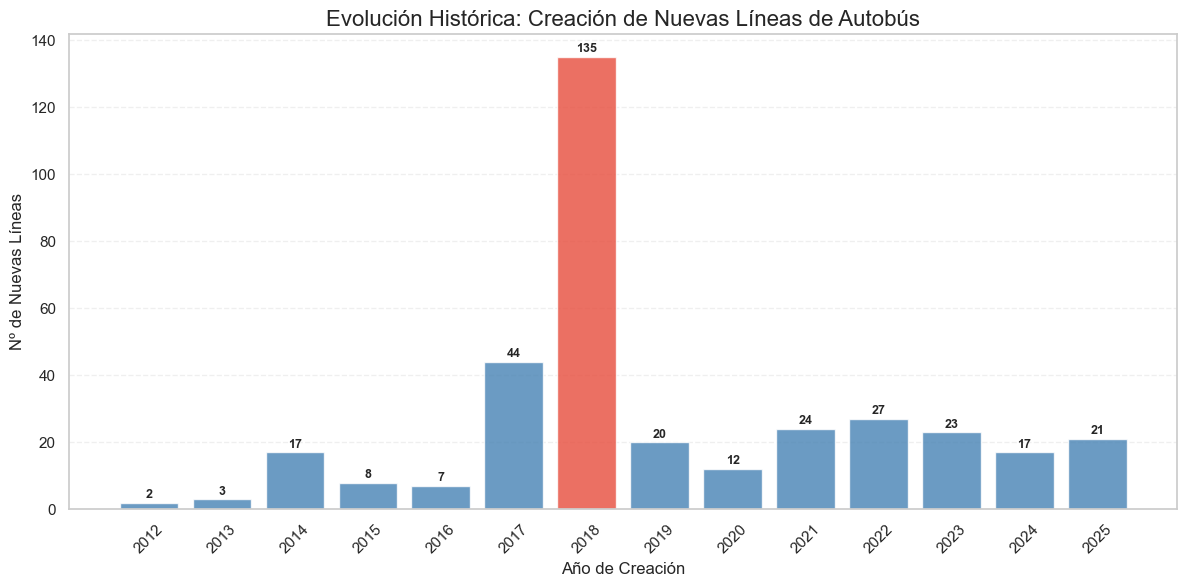

In [75]:
plt.figure(figsize=(12, 6))

colores = ['#e74c3c' if x == conteo_anual.max() else 'steelblue' for x in conteo_anual.values]

barras = plt.bar(conteo_anual.index.astype(int), conteo_anual.values, 
                 color=colores, alpha=0.8, width=0.8)

plt.title('Evolución Histórica: Creación de Nuevas Líneas de Autobús', fontsize=16)
plt.xlabel('Año de Creación', fontsize=12)
plt.ylabel('Nº de Nuevas Líneas', fontsize=12)

max_val = conteo_anual.max()
for barra in barras:
    height = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., height + 0.5,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.grid(axis='x', alpha=0)

plt.xticks(conteo_anual.index.astype(int), rotation=45)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_temporal_bus/1_barras_evolucion_anual.png', dpi=300)
plt.show()

- Histograma (Distribución): Para ver la "Distribución de la longevidad de las líneas". Nos ayudará a entender si la mayoría de líneas duran poco, mucho, o si hay una distribución normal.

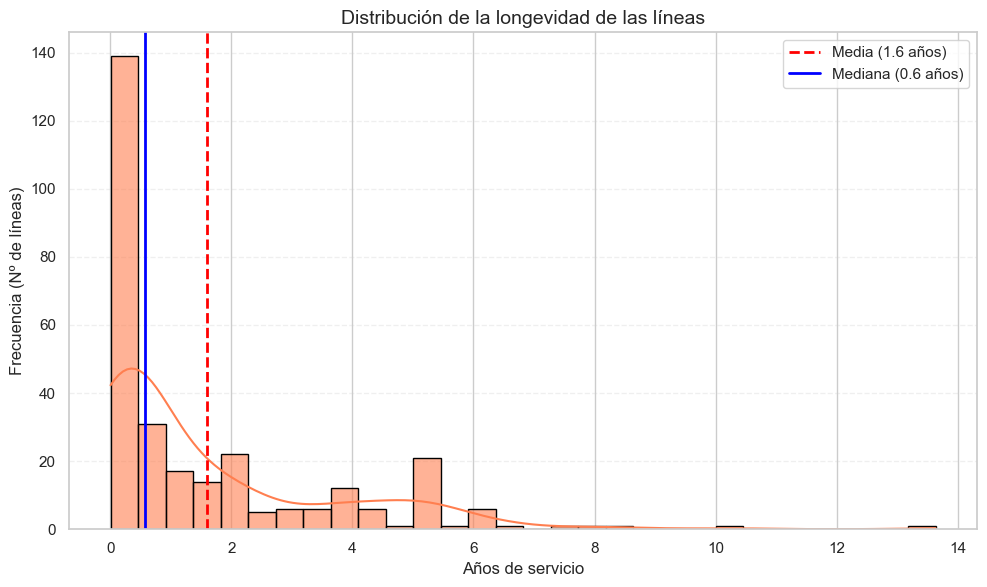

In [76]:
plt.figure(figsize=(10, 6))

# 1. Preparar datos (Días -> Años)
duracion_anios = df_duracion_valid['duracion_dias'] / 365

# 2. Graficar Histograma con KDE
sns.histplot(duracion_anios, bins=30, kde=True, 
             color='coral', edgecolor='black', alpha=0.6)

# 3. Líneas de referencia
media = duracion_anios.mean()
mediana = duracion_anios.median()

plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media ({media:.1f} años)')
plt.axvline(mediana, color='blue', linestyle='-', linewidth=2, label=f'Mediana ({mediana:.1f} años)')

# 4. Decoración
plt.title('Distribución de la longevidad de las líneas', fontsize=14)
plt.xlabel('Años de servicio', fontsize=12)
plt.ylabel('Frecuencia (Nº de líneas)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_temporal_bus/2_histograma_longevidad.png', dpi=300)
plt.show()

- Gráfico de Sectores / Pie Chart (Composición): Para comparar el porcentaje de "Líneas Regulares vs. Especiales".

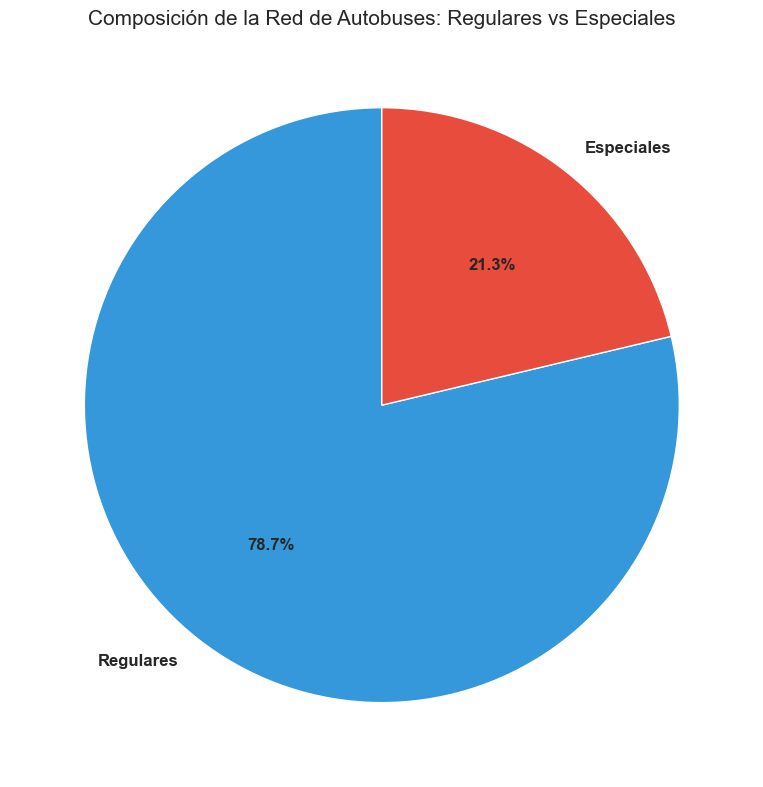

In [77]:
plt.figure(figsize=(8, 8))

colors = ['#3498db', '#e74c3c']
explode = (0.05, 0)

plt.pie(conteo_tipos.values, 
        labels=conteo_tipos.index, 
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        textprops={'fontsize': 12, 'fontweight': 'bold'}
       )

plt.title('Composición de la Red de Autobuses: Regulares vs Especiales', fontsize=15)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_temporal_bus/3_pie_tipos_linea.png', dpi=300)
plt.show()

- Gráfico de Barras Horizontales (Ranking): Para mostrar el "Top 10 Depósitos con más líneas". Las barras horizontales son mejores cuando las etiquetas (nombres de depósitos) son texto.

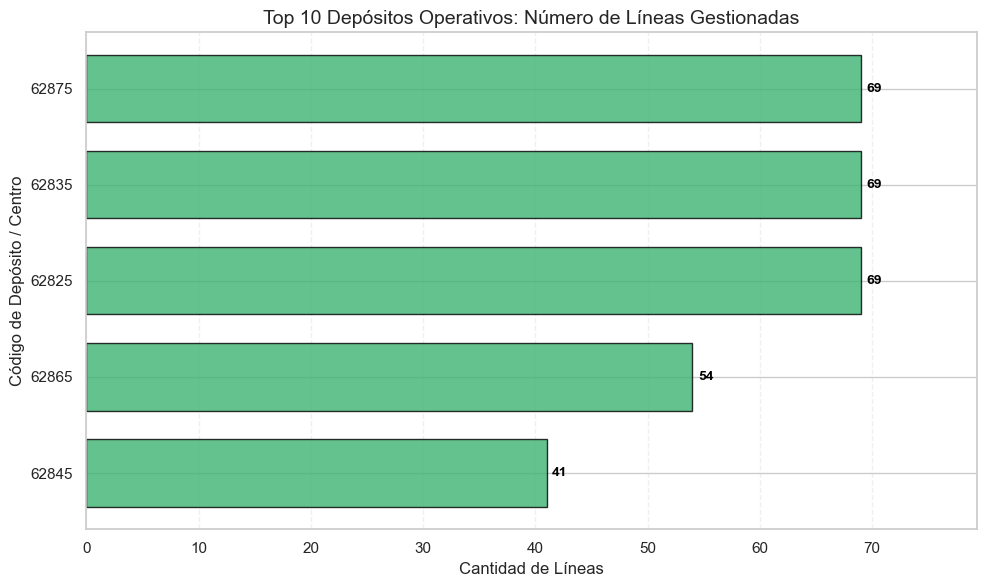

In [78]:
plt.figure(figsize=(10, 6))

lineas_por_deposito = df_lines.groupby('line')['depo'].first().value_counts()
top_depositos_plot = lineas_por_deposito.head(10).sort_values(ascending=True)

y_posiciones = range(len(top_depositos_plot))

rects = plt.barh(y_posiciones, top_depositos_plot.values, 
                 color='mediumseagreen', edgecolor='black', alpha=0.8, height=0.7)

plt.yticks(y_posiciones, top_depositos_plot.index, fontsize=11)

plt.title('Top 10 Depósitos Operativos: Número de Líneas Gestionadas', fontsize=14)
plt.xlabel('Cantidad de Líneas', fontsize=12)
plt.ylabel('Código de Depósito / Centro', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for rect in rects:
    width = rect.get_width()
    plt.text(width + 0.5, rect.get_y() + rect.get_height()/2., 
             f'{int(width)}', 
             ha='left', va='center', fontsize=10, fontweight='bold', color='black')

plt.xlim(0, top_depositos_plot.max() * 1.15)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_temporal_bus/4_ranking_depositos.png', dpi=300)
plt.show()

- Gráfico de Barras Horizontales (Ranking): Para visualizar el "Top 10 Líneas más longevas".

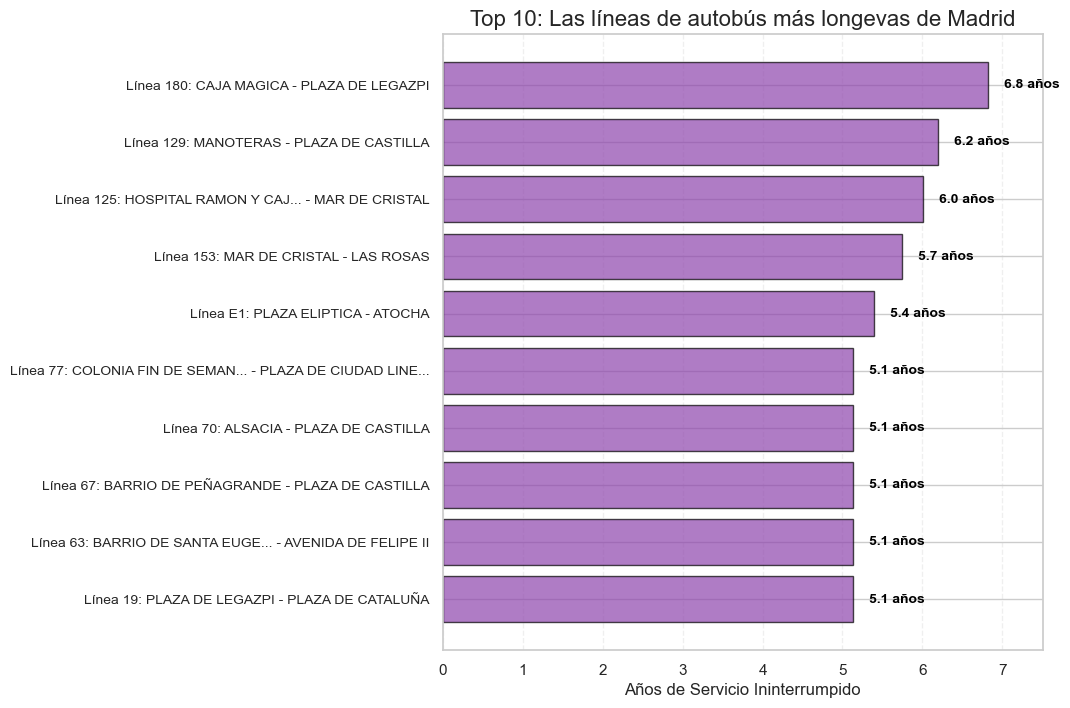

In [83]:
plt.figure(figsize=(12, 8))

def crear_etiqueta_corta(row):
    origen = str(row['nameFrom'])[:20] + ("..." if len(str(row['nameFrom'])) > 20 else "")
    destino = str(row['nameTo'])[:20] + ("..." if len(str(row['nameTo'])) > 20 else "")
    return f"Línea {row['label']}: {origen} - {destino}"

top_longevas['label_full_short'] = top_longevas.apply(crear_etiqueta_corta, axis=1)

y_pos = range(len(top_longevas))
barras = plt.barh(y_pos, top_longevas['duracion_anos'],
                  color='#8e44ad', edgecolor='black', alpha=0.7)

plt.yticks(y_pos, top_longevas['label_full_short'], fontsize=10)
plt.xlabel('Años de Servicio Ininterrumpido', fontsize=12)
plt.title('Top 10: Las líneas de autobús más longevas de Madrid', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for barra in barras:
    width = barra.get_width()
    plt.text(width + 0.2, barra.get_y() + barra.get_height()/2,
             f'{width:.1f} años',
             ha='left', va='center', fontweight='bold', color='black', fontsize=10)

plt.xlim(0, top_longevas['duracion_anos'].max() * 1.1)

plt.subplots_adjust(left=0.4)

plt.savefig('resultados/plots/analisis_temporal_bus/5_ranking_longevidad_ajustado.png', dpi=300)
plt.show()

### Análisis de Estado y Disponibilidad de Infraestructura BiciMAD

In [84]:
lat_centro = df_bicimad['stop_lat'].median()
lon_centro = df_bicimad['stop_lon'].median()

def clasificar_cuadrante(row):
    ns = 'N' if row['stop_lat'] >= lat_centro else 'S'
    eo = 'E' if row['stop_lon'] >= lon_centro else 'O'
    
    nombres = {
        'NE': 'Noreste (NE)',
        'NO': 'Noroeste (NO)',
        'SE': 'Sureste (SE)',
        'SO': 'Suroeste (SO)'
    }
    return nombres.get(f"{ns}{eo}", "Desconocido")

df_bicimad['cuadrante'] = df_bicimad.apply(clasificar_cuadrante, axis=1)

estados_count = df_bicimad['state'].value_counts()
top_capacidad = df_bicimad.nlargest(10, 'capacity').sort_values('capacity', ascending=True)
capacidad_cuadrante = df_bicimad.groupby('cuadrante')['capacity'].sum().sort_values(ascending=True)

- Histograma (con curva KDE): Para la "Distribución de la Capacidad". Nos permitirá ver cuál es el tamaño "típico" de una estación y si hay muchas estaciones pequeñas o grandes.

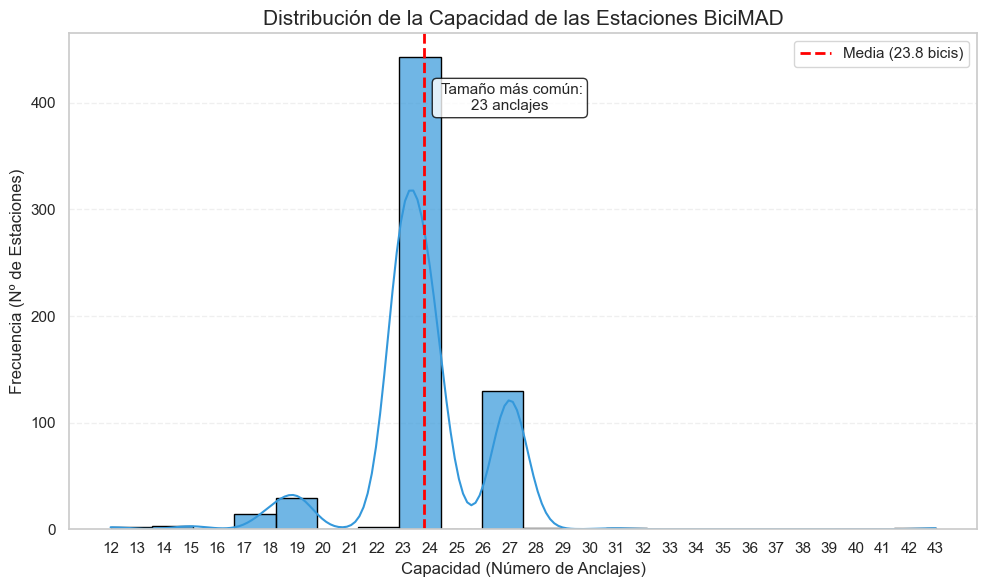

In [88]:
plt.figure(figsize=(10, 6))

datos_capacidad = df_bicimad['capacity']

sns.histplot(datos_capacidad, bins=20, kde=True, 
             color='#3498db', edgecolor='black', alpha=0.7)

media = datos_capacidad.mean()
moda = datos_capacidad.mode()[0]

plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media ({media:.1f} bicis)')

plt.title('Distribución de la Capacidad de las Estaciones BiciMAD', fontsize=15)
plt.xlabel('Capacidad (Número de Anclajes)', fontsize=12)
plt.ylabel('Frecuencia (Nº de Estaciones)', fontsize=12)

plt.text(moda+4, plt.gca().get_ylim()[1]*0.9, f' Tamaño más común:\n{int(moda)} anclajes', 
         ha='center', va='top', bbox=dict(boxstyle="round", fc="white", ec="black", alpha=0.8))

xticks = range(int(datos_capacidad.min()), int(datos_capacidad.max()) + 1)
plt.xticks(xticks)

plt.legend()
plt.grid(axis='x', linestyle='--', alpha=0)
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_bicimad/2_histograma_capacidad.png', dpi=300)
plt.show()

- Gráfico de Barras Horizontales: Para el "Top 10 Estaciones con Mayor Capacidad". Imprescindible para identificar los "hubs" principales de la red.

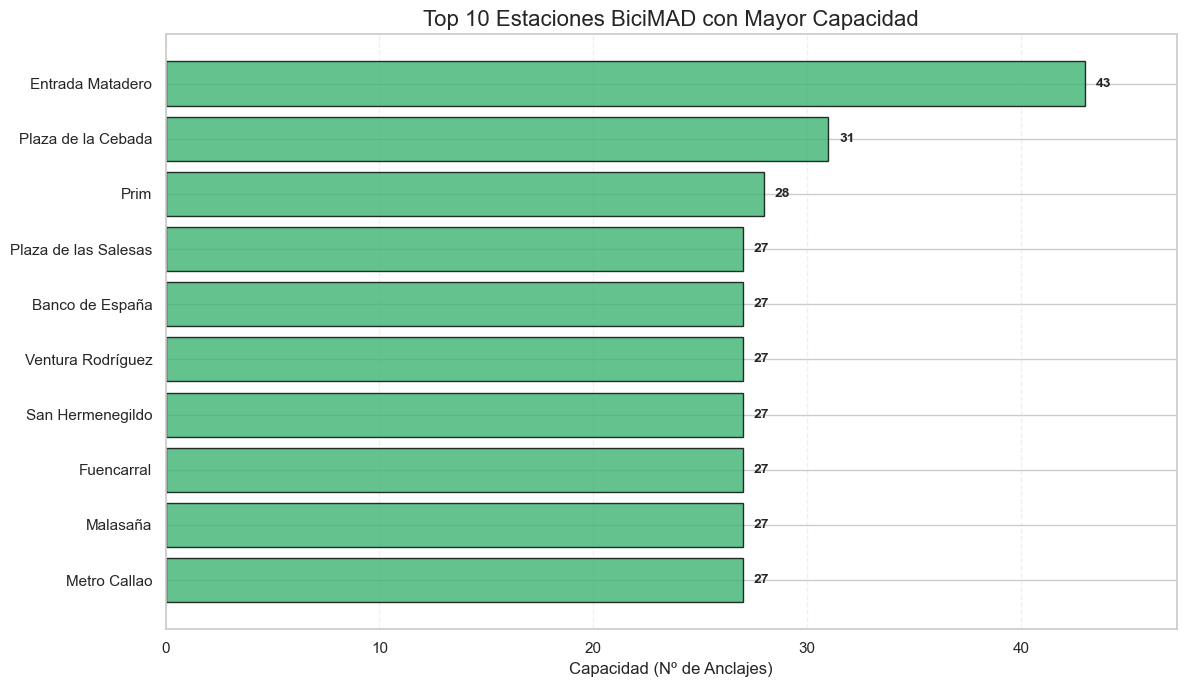

In [89]:
plt.figure(figsize=(12, 7))

y_pos = range(len(top_capacidad))
barras = plt.barh(y_pos, top_capacidad['capacity'], 
                  color='mediumseagreen', edgecolor='black', alpha=0.8)

nombres_limpios = [nombre[:35] + '...' if len(nombre) > 35 else nombre 
                   for nombre in top_capacidad['station_name']]
plt.yticks(y_pos, nombres_limpios, fontsize=11)

plt.title('Top 10 Estaciones BiciMAD con Mayor Capacidad', fontsize=16)
plt.xlabel('Capacidad (Nº de Anclajes)', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for barra in barras:
    width = barra.get_width()
    plt.text(width + 0.5, barra.get_y() + barra.get_height()/2, 
             f'{int(width)}', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.xlim(0, top_capacidad['capacity'].max() * 1.1)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_bicimad/3_ranking_capacidad.png', dpi=300)
plt.show()

- Gráfico de Barras Verticales: Para la "Capacidad Total por Cuadrante". Para visualizar si la oferta de bicis está equilibrada entre el Norte, Sur, Este y Oeste de la ciudad.

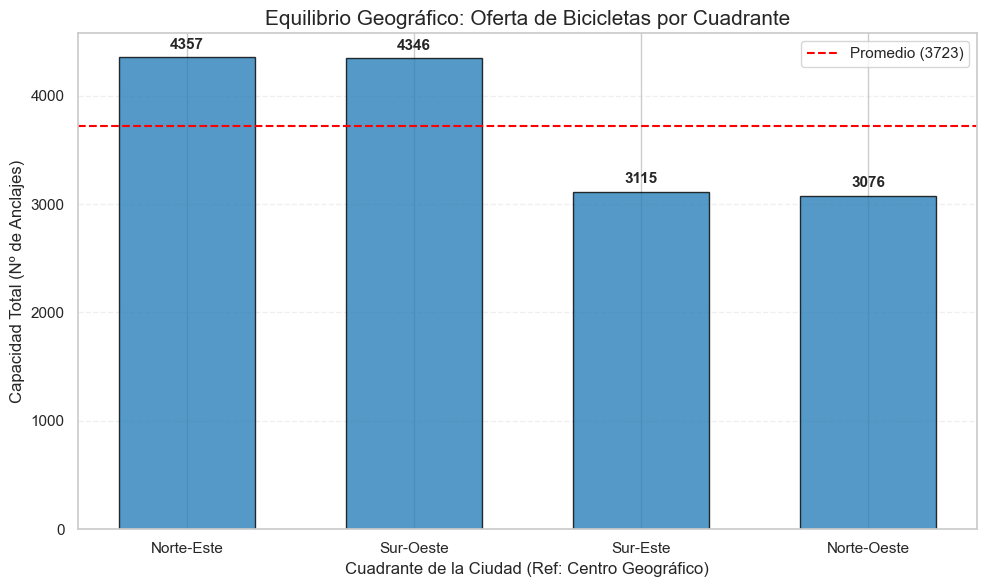

In [91]:
plt.figure(figsize=(10, 6))

lat_centro = df_bicimad['stop_lat'].median()
lon_centro = df_bicimad['stop_lon'].median()

def get_cuadrante(row):
    ns = 'Norte' if row['stop_lat'] >= lat_centro else 'Sur'
    eo = 'Este' if row['stop_lon'] >= lon_centro else 'Oeste'
    return f"{ns}-{eo}"

df_bicimad['cuadrante_geo'] = df_bicimad.apply(get_cuadrante, axis=1)

capacidad_zona = df_bicimad.groupby('cuadrante_geo')['capacity'].sum().sort_values(ascending=False)


barras = plt.bar(capacidad_zona.index, capacidad_zona.values, 
                 color='#2980b9', edgecolor='black', alpha=0.8, width=0.6)

plt.title('Equilibrio Geográfico: Oferta de Bicicletas por Cuadrante', fontsize=15)
plt.ylabel('Capacidad Total (Nº de Anclajes)', fontsize=12)
plt.xlabel('Cuadrante de la Ciudad (Ref: Centro Geográfico)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

promedio = capacidad_zona.mean()
plt.axhline(promedio, color='red', linestyle='--', label=f'Promedio ({int(promedio)})')
plt.legend()

for barra in barras:
    height = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., height + 50,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('resultados/plots/analisis_bicimad/5_barras_cuadrantes.png', dpi=300)
plt.show()

### Parkings

In [92]:
df_parkings['total_capacity'] = df_parkings['standard_spaces'] + df_parkings['pmr_spaces']
df_parkings['pmr_percent'] = (df_parkings['pmr_spaces'] / df_parkings['total_capacity']) * 100

lat_centro = df_parkings['stop_lat'].median()
lon_centro = df_parkings['stop_lon'].median()

def clasificar_cuadrante(row):
    ns = 'Norte' if row['stop_lat'] >= lat_centro else 'Sur'
    eo = 'Este' if row['stop_lon'] >= lon_centro else 'Oeste'
    return f"{ns}-{eo}"

df_parkings['cuadrante'] = df_parkings.apply(clasificar_cuadrante, axis=1)

top_parkings = df_parkings.nlargest(10, 'total_capacity').sort_values('total_capacity', ascending=True)

capacidad_zona_parking = df_parkings.groupby('cuadrante')['total_capacity'].sum().sort_values(ascending=False)

total_standard = df_parkings['standard_spaces'].sum()
total_pmr = df_parkings['pmr_spaces'].sum()

- Histograma de Capacidad Total: Para ver el "Tamaño típico de un parking". ¿La mayoría son pequeños (<200 plazas) o hay muchos macro-parkings?

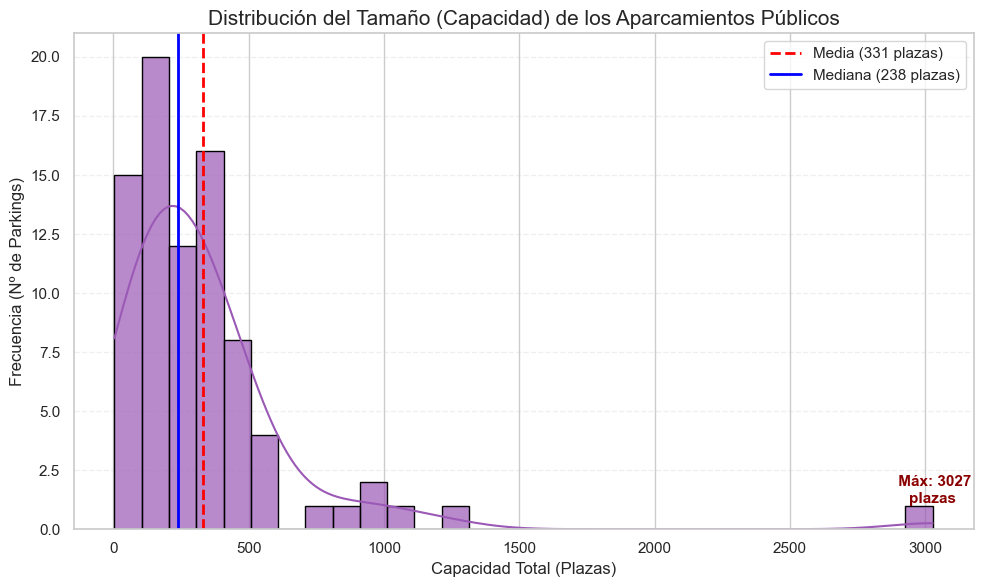

In [93]:
plt.figure(figsize=(10, 6))

datos = df_parkings['total_capacity']

sns.histplot(datos, bins=30, kde=True, 
             color='#9b59b6', edgecolor='black', alpha=0.7)

media = datos.mean()
mediana = datos.median()

plt.axvline(media, color='red', linestyle='--', linewidth=2, label=f'Media ({media:.0f} plazas)')
plt.axvline(mediana, color='blue', linestyle='-', linewidth=2, label=f'Mediana ({mediana:.0f} plazas)')

plt.title('Distribución del Tamaño (Capacidad) de los Aparcamientos Públicos', fontsize=15)
plt.xlabel('Capacidad Total (Plazas)', fontsize=12)
plt.ylabel('Frecuencia (Nº de Parkings)', fontsize=12)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.3)

max_val = datos.max()
plt.text(max_val, 1, f' Máx: {int(max_val)}\nplazas', 
         ha='center', va='bottom', color='darkred', fontweight='bold')

plt.tight_layout()
plt.savefig('resultados/plots/analisis_parkings/1_histograma_capacidad.png', dpi=300)
plt.show()

- Ranking (Barras Horizontales): "Top 10 Aparcamientos más grandes". Para identificar las infraestructuras críticas (ej: Colón, Plaza Mayor, etc.).

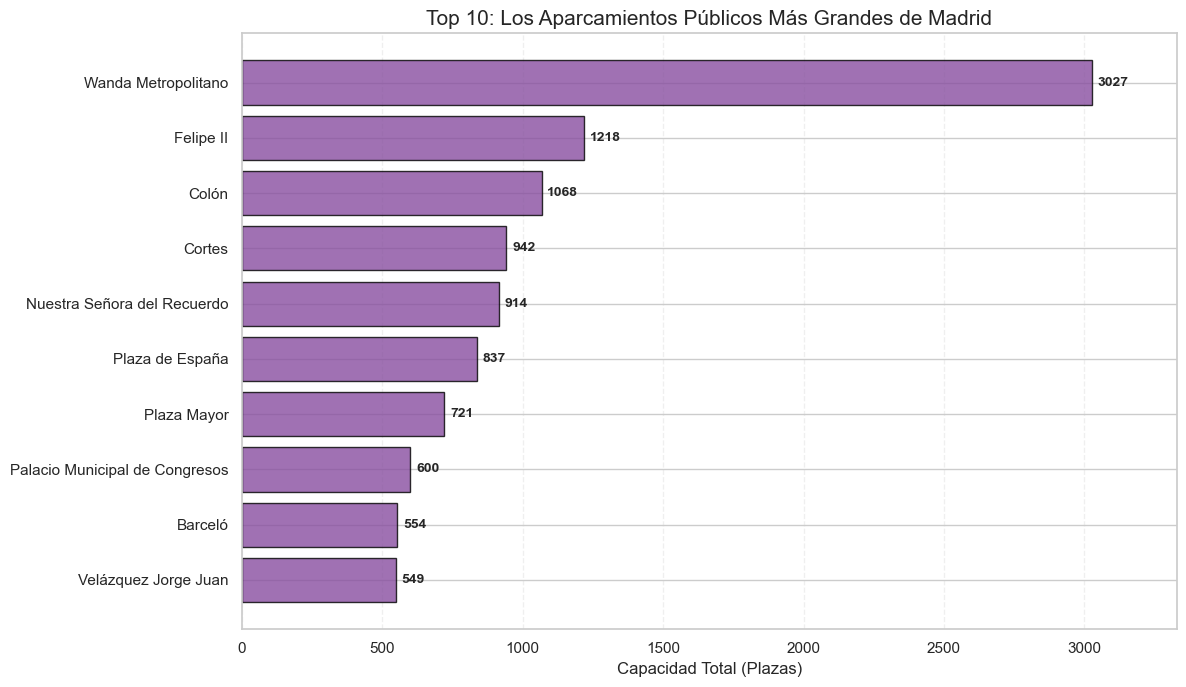

In [94]:
plt.figure(figsize=(12, 7))

def acortar_nombre(nombre):
    nombre = str(nombre).strip()
    return nombre[:35] + '...' if len(nombre) > 35 else nombre

nombres_plot = top_parkings['parking_name'].apply(acortar_nombre)

y_pos = range(len(top_parkings))
barras = plt.barh(y_pos, top_parkings['total_capacity'], 
                  color='#884ea0', edgecolor='black', alpha=0.8)

plt.yticks(y_pos, nombres_plot, fontsize=11)
plt.xlabel('Capacidad Total (Plazas)', fontsize=12)
plt.title('Top 10: Los Aparcamientos Públicos Más Grandes de Madrid', fontsize=15)
plt.grid(axis='x', linestyle='--', alpha=0.3)

for barra in barras:
    width = barra.get_width()
    plt.text(width + 20, barra.get_y() + barra.get_height()/2, 
             f'{int(width)}', 
             ha='left', va='center', fontweight='bold', fontsize=10)

plt.xlim(0, top_parkings['total_capacity'].max() * 1.1)

plt.tight_layout()
plt.savefig('resultados/plots/analisis_parkings/2_ranking_capacidad.png', dpi=300)
plt.show()

- Scatter Plot (Dispersión): "Relación Plazas Totales vs. Plazas PMR". Este es clave para accesibilidad. Nos permitirá ver visualmente qué parkings cumplen con la ratio (puntos por encima de una línea diagonal) y cuáles se quedan cortos.

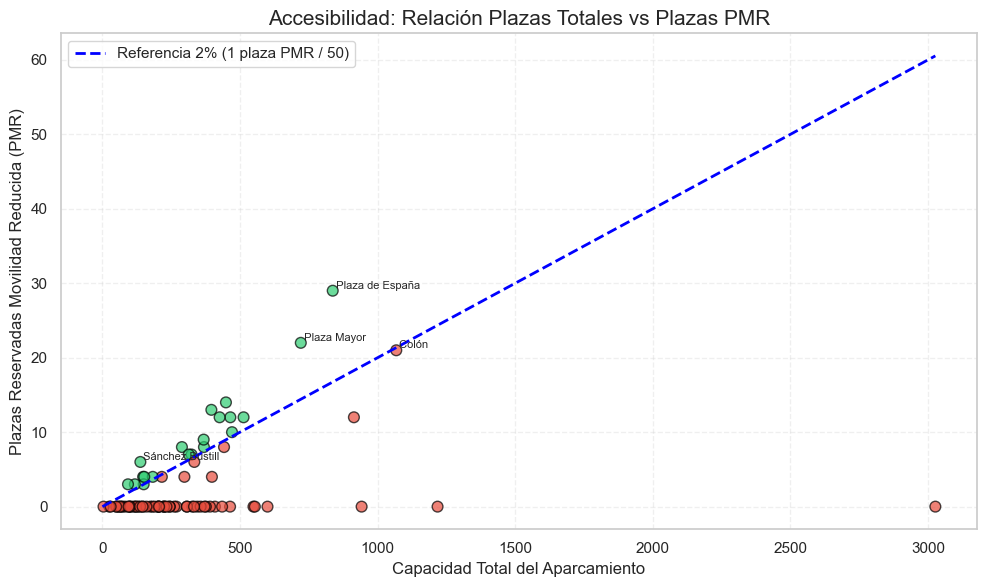

In [95]:
plt.figure(figsize=(10, 6))

x = df_parkings['total_capacity']
y = df_parkings['pmr_spaces']

ratio_referencia = 0.02

colores = []
for pmr, tot in zip(y, x):
    if tot > 0:
        if (pmr / tot) >= ratio_referencia:
            colores.append('#2ecc71')
        else:
            colores.append('#e74c3c')
    else:
        colores.append('gray')

plt.scatter(x, y, c=colores, alpha=0.7, edgecolors='black', s=60)

x_line = np.array([0, x.max()])
y_line = x_line * ratio_referencia
plt.plot(x_line, y_line, color='blue', linestyle='--', linewidth=2, 
         label='Referencia 2% (1 plaza PMR / 50)')

plt.title('Accesibilidad: Relación Plazas Totales vs Plazas PMR', fontsize=15)
plt.xlabel('Capacidad Total del Aparcamiento', fontsize=12)
plt.ylabel('Plazas Reservadas Movilidad Reducida (PMR)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)

for i, row in df_parkings.iterrows():
    if row['total_capacity'] > 100:
        ratio = row['pmr_spaces'] / row['total_capacity']
        if ratio > 0.04 or row['pmr_spaces'] > 20:
            plt.text(row['total_capacity'], row['pmr_spaces'], 
                     f" {str(row['parking_name'])[:15]}", fontsize=8, va='bottom')

plt.tight_layout()
plt.savefig('resultados/plots/analisis_parkings/3_scatter_pmr.png', dpi=300)
plt.show()

- Gráfico de Barras Verticales (Geográfico): "Oferta de Plazas por Cuadrante". Igual que en BiciMAD, para ver si hay más aparcamiento en el Norte, Sur, Este u Oeste.

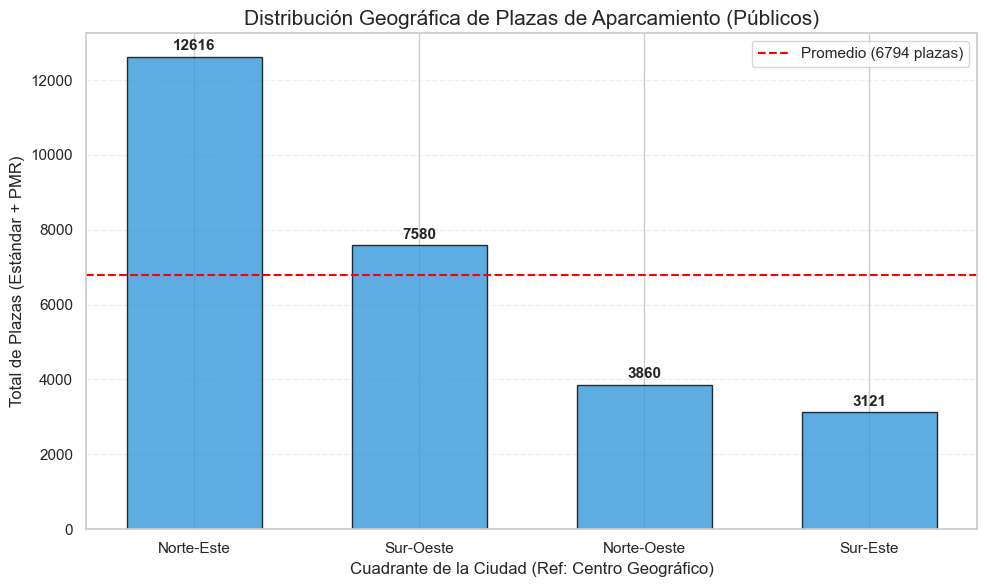

In [96]:
if 'total_capacity' not in df_parkings.columns:
    df_parkings['total_capacity'] = df_parkings['standard_spaces'] + df_parkings['pmr_spaces']

lat_centro = df_parkings['stop_lat'].median()
lon_centro = df_parkings['stop_lon'].median()

def clasificar_cuadrante(row):
    ns = 'Norte' if row['stop_lat'] >= lat_centro else 'Sur'
    eo = 'Este' if row['stop_lon'] >= lon_centro else 'Oeste'
    return f"{ns}-{eo}"

df_parkings['cuadrante'] = df_parkings.apply(clasificar_cuadrante, axis=1)

capacidad_zona = df_parkings.groupby('cuadrante')['total_capacity'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))

barras = plt.bar(capacidad_zona.index, capacidad_zona.values, 
                 color='#3498db', edgecolor='black', alpha=0.8, width=0.6)

plt.title('Distribución Geográfica de Plazas de Aparcamiento (Públicos)', fontsize=15)
plt.ylabel('Total de Plazas (Estándar + PMR)', fontsize=12)
plt.xlabel('Cuadrante de la Ciudad (Ref: Centro Geográfico)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.3)

promedio = capacidad_zona.mean()
plt.axhline(promedio, color='red', linestyle='--', label=f'Promedio ({int(promedio)} plazas)')
plt.legend()

for barra in barras:
    height = barra.get_height()
    plt.text(barra.get_x() + barra.get_width()/2., height + 100,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('resultados/plots/analisis_parkings/4_barras_cuadrantes.png', dpi=300)
plt.show()

# 4. Análisis viajeros metro de Madrid

In [100]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [10, 6]

output_dir = 'resultados/plots/analisis_viajeros_metro'
os.makedirs(output_dir, exist_ok=True)

str_cols = df_viajes.select_dtypes(['object']).columns
for col in str_cols:
    df_viajes[col] = df_viajes[col].str.strip()

df_viajes['personas'] = pd.to_numeric(df_viajes['personas'], errors='coerce')

df_viajes['fecha'] = df_viajes['fecha'].astype(str)

order_viajes = ['0', '1', '2', '2+']
df_viajes['numero_viajes'] = pd.Categorical(df_viajes['numero_viajes'], categories=order_viajes, ordered=True)


### Análisis de Movilidad por Edad y Sexo

- Analizamos qué grupos demográficos realizan más desplazamientos. Sumamos el total de 'personas' (o días-persona) observadas en cada grupo.

Gráfico guardado en: resultados/plots/analisis_viajeros_metro/movilidad_edad_sexo.png


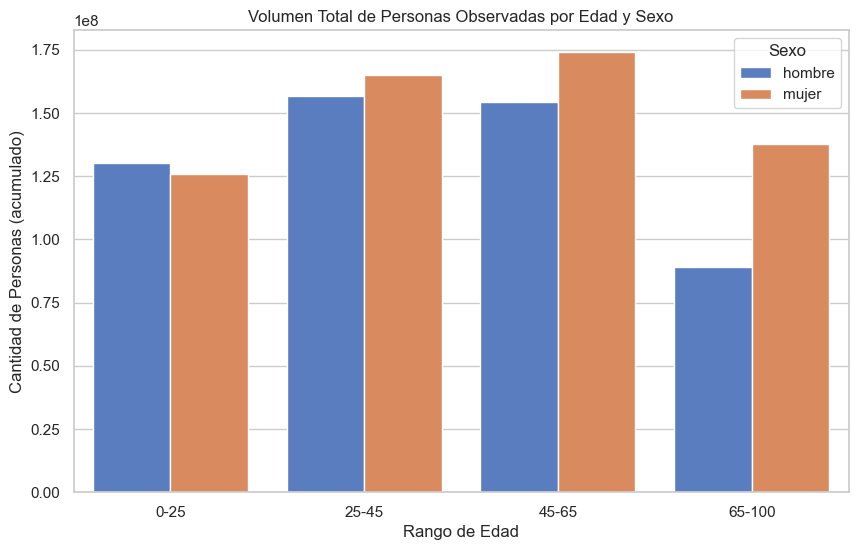

In [101]:
df_demo = df_viajes.groupby(['edad', 'sexo'])['personas'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=df_demo, x='edad', y='personas', hue='sexo', palette='muted')
plt.title('Volumen Total de Personas Observadas por Edad y Sexo')
plt.ylabel('Cantidad de Personas (acumulado)')
plt.xlabel('Rango de Edad')
plt.legend(title='Sexo')

save_path = f"{output_dir}/movilidad_edad_sexo.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")

plt.show()

### Ranking de Tasa de Movilidad por Distrito

- Calculamos qué porcentaje de la población observada en cada distrito realiza al menos un viaje (`numero_viajes != 0`).

/var/folders/_3/0gph01y11sbcxhlpqy_l7w680000gn/T/ipykernel_87227/3451917407.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=tasa_movilidad, y='name', x='tasa', palette='viridis')


Gráfico guardado en: resultados/plots/analisis_viajeros_metro/ranking_tasa_movilidad_distritos.png


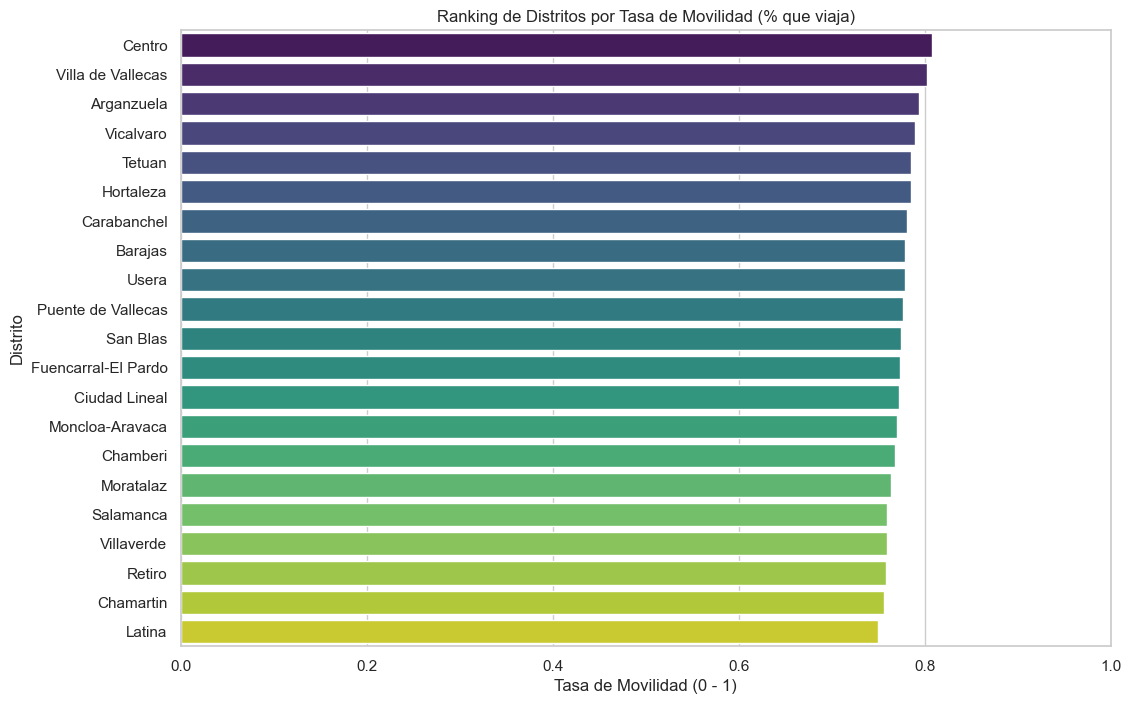

In [102]:
total_por_distrito = df_viajes.groupby('name')['personas'].sum()

viajeros_por_distrito = df_viajes[df_viajes['numero_viajes'] != '0'].groupby('name')['personas'].sum()

tasa_movilidad = (viajeros_por_distrito / total_por_distrito).sort_values(ascending=False).reset_index(name='tasa')

plt.figure(figsize=(12, 8))
sns.barplot(data=tasa_movilidad, y='name', x='tasa', palette='viridis')
plt.title('Ranking de Distritos por Tasa de Movilidad (% que viaja)')
plt.xlabel('Tasa de Movilidad (0 - 1)')
plt.ylabel('Distrito')
plt.xlim(0, 1)

save_path = f"{output_dir}/ranking_tasa_movilidad_distritos.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")

plt.show()

### Distribución de Frecuencia de Viajes

- ¿Cuántos viajes suele hacer la gente? Analizamos la proporción de personas sedentarias vs viajeras frecuentes.

Gráfico guardado en: resultados/plots/analisis_viajeros_metro/distribucion_hub_viajes.png


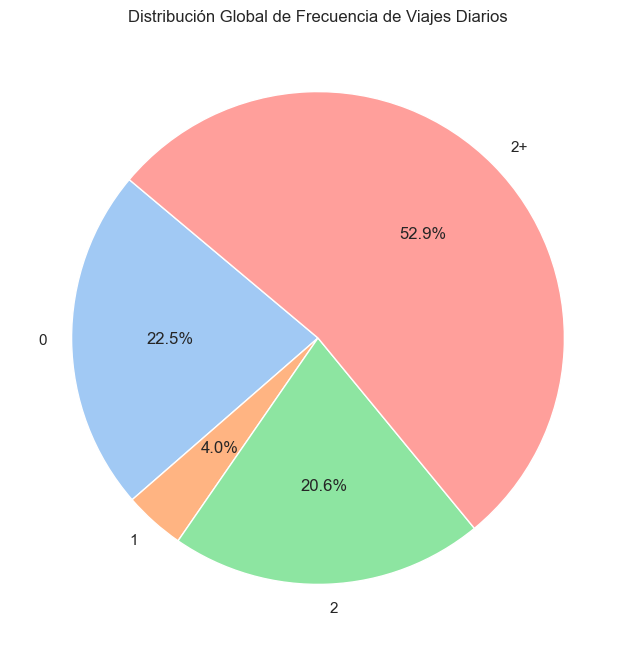

In [103]:
df_freq = df_viajes.groupby('numero_viajes', observed=False)['personas'].sum()

plt.figure(figsize=(8, 8))
colores = sns.color_palette('pastel')
plt.pie(df_freq, labels=df_freq.index, autopct='%1.1f%%', startangle=140, colors=colores)
plt.title('Distribución Global de Frecuencia de Viajes Diarios')

# Guardar gráfico
save_path = f"{output_dir}/distribucion_hub_viajes.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")

plt.show()

### Evolución Temporal (Enero vs Febrero)

- Comparamos la cantidad total de personas que se desplazan (viajes > 0) entre los diferentes meses registrados.

Gráfico guardado en: resultados/plots/analisis_viajeros_metro/evolucion_temporal_viajes.png


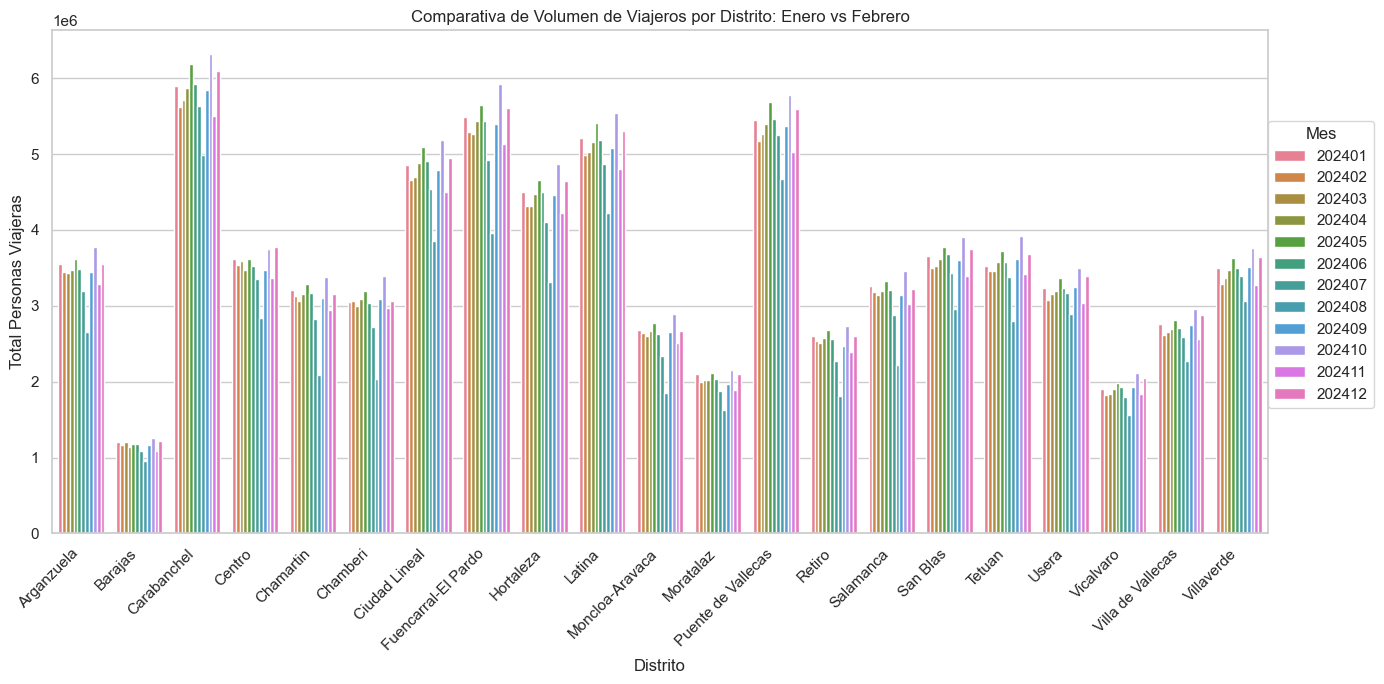

In [104]:
df_movil = df_viajes[df_viajes['numero_viajes'] != '0']

df_temp = df_movil.groupby(['name', 'fecha'])['personas'].sum().reset_index()

plt.figure(figsize=(14, 7))
sns.barplot(data=df_temp, x='name', y='personas', hue='fecha')
plt.xticks(rotation=45, ha='right')
plt.title('Comparativa de Volumen de Viajeros por Distrito: Enero vs Febrero')
plt.xlabel('Distrito')
plt.ylabel('Total Personas Viajeras')
plt.legend(title='Mes', loc=(1,0.25))
plt.tight_layout()

save_path = f"{output_dir}/evolucion_temporal_viajes.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")

plt.show()

### Análisis de Intensidad de Viaje por Distrito

- Analizamos específicamente a los usuarios intensivos (2+ viajes) por distrito, para ver dónde se concentra la mayor actividad.

Gráfico guardado en: resultados/plots/analisis_viajeros_metro/intensidad_alta_movilidad_distritos.png


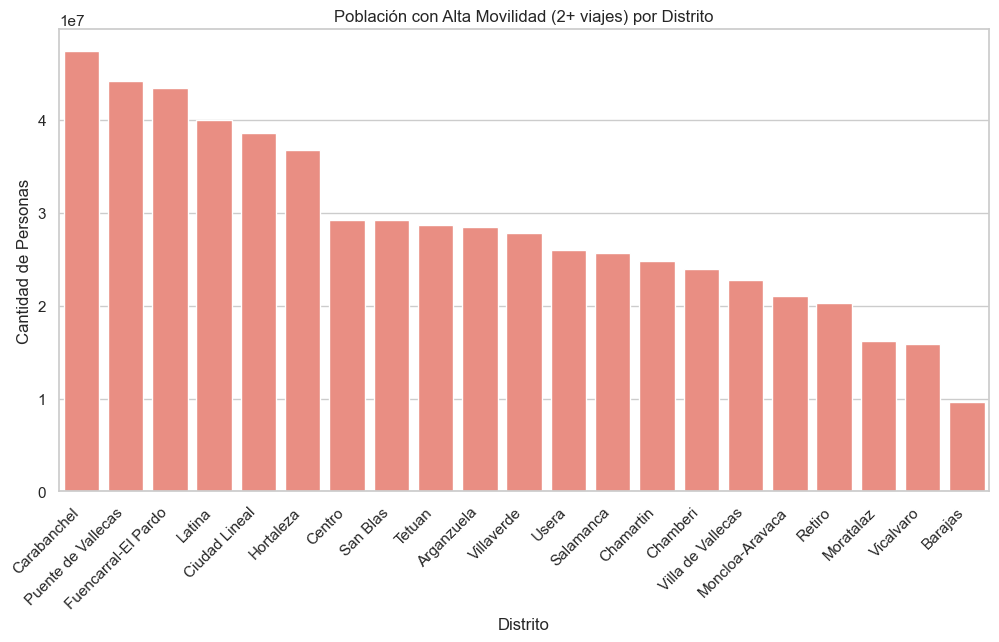

In [105]:
df_intensivos = df_viajes[df_viajes['numero_viajes'] == '2+'].groupby('name')['personas'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=df_intensivos, x='name', y='personas', color='salmon')
plt.xticks(rotation=45, ha='right')
plt.title('Población con Alta Movilidad (2+ viajes) por Distrito')
plt.xlabel('Distrito')
plt.ylabel('Cantidad de Personas')

# Guardar gráfico
save_path = f"{output_dir}/intensidad_alta_movilidad_distritos.png"
plt.savefig(save_path, bbox_inches='tight')
print(f"Gráfico guardado en: {save_path}")

plt.show()

### Mapa Coroplético de Intensidad de Viajes

Visualizamos la concentración de viajeros frecuentes (2+ viajes) sobre el mapa de los distritos de Madrid.

In [ ]:
geo_url = 'https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/madrid-districts.geojson'

response = requests.get(geo_url)
madrid_geo = response.json()

df_intensivos['name'] = df_intensivos['name'].str.strip()

m = folium.Map(location=[40.4168, -3.7038], zoom_start=11, tiles='CartoDB positron')

folium.Choropleth(
    geo_data=madrid_geo,
    name='choropleth',
    data=df_intensivos,
    columns=['name', 'personas'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Número de Personas con 2+ Viajes'
).add_to(m)

folium.LayerControl().add_to(m)

mapa_salida = f'{output_dir}/mapa_intensidad_viajes.html'
m.save(mapa_salida)

Descargando GeoJSON de: https://raw.githubusercontent.com/codeforgermany/click_that_hood/main/public/data/madrid-districts.geojson ...


NameError: name 'requests' is not defined